In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

from darts.utils.statistics import extract_trend_and_seasonality
from darts.utils.utils import ModelMode 

from statsmodels.graphics.gofplots import qqplot
from sklearn.metrics import r2_score

import matplotlib.cm as cm
from matplotlib.lines import Line2D

from utils import *
import pickle

In [2]:
data_folder = "./data"
results_folder = "./results"
figures_folder = "./figures"

In [3]:
data_demo_fname = "{}/mozambique_demographics_by_province.csv".format(data_folder)
df_demo = read_provinces_timeseries_data(data_demo_fname)
provinces0 = df_demo.columns
df_demo = df_demo.rename(columns={'MAPUTO CIDADE':'MAPUTO CITY'})
df_demo = df_demo.rename(columns={'MAPUTO PROVINCIA':'MAPUTO'})

coverage_fname = "{}/weekly_coverage_per_province.csv".format(data_folder)
df_coverage = read_provinces_timeseries_data(coverage_fname)
df_coverage = df_coverage.rename(columns={'MAPUTO CIDADE':'MAPUTO CITY'})
df_coverage = df_coverage.rename(columns={'MAPUTO PROVINCIA':'MAPUTO'})

data_type = "malaria" 
data_fname = "{}/mozambique_{}_cases_by_province.csv".format(data_folder,data_type)
df_malaria_cases_wide = read_provinces_timeseries_data(data_fname)
df_malaria_cases_wide = df_malaria_cases_wide.rename(columns={'MAPUTO CIDADE':'MAPUTO CITY'})
df_malaria_cases_wide = df_malaria_cases_wide.rename(columns={'MAPUTO PROVINCIA':'MAPUTO'})
df_malaria_cases = pd.melt(df_malaria_cases_wide.reset_index(),
                            id_vars='date',value_vars=df_malaria_cases_wide.columns,
                            var_name='province',value_name='value')
df_malaria_rates_wide = 1e5*df_malaria_cases_wide/(df_demo*df_coverage)
df_malaria_rates = pd.melt(df_malaria_rates_wide.reset_index(),
                            id_vars='date',value_vars=df_malaria_rates_wide.columns,
                            var_name='province',value_name='value')

data_type = "diarrhea"
data_fname = "{}/mozambique_{}_cases_by_province.csv".format(data_folder,data_type)
df_diarrhea_cases_wide = read_provinces_timeseries_data(data_fname)
df_diarrhea_cases_wide = df_diarrhea_cases_wide.rename(columns={'MAPUTO CIDADE':'MAPUTO CITY'})
df_diarrhea_cases_wide = df_diarrhea_cases_wide.rename(columns={'MAPUTO PROVINCIA':'MAPUTO'})
df_diarrhea_cases = pd.melt(df_diarrhea_cases_wide.reset_index(),
                            id_vars='date',value_vars=df_diarrhea_cases_wide.columns,
                            var_name='province',value_name='value')
df_diarrhea_rates_wide = 1e5*df_diarrhea_cases_wide/(df_demo*df_coverage)
df_diarrhea_rates = pd.melt(df_diarrhea_rates_wide.reset_index(),
                            id_vars='date',value_vars=df_diarrhea_rates_wide.columns,
                            var_name='province',value_name='value')


df_malaria_rates['data'] = 'malaria'
df_diarrhea_rates['data'] = 'diarrhea'
df_rates = pd.concat([df_malaria_rates,df_diarrhea_rates])

malaria_rates = np.round(df_rates[df_rates.data=='malaria'].groupby(['province'])['value'].mean(),1)
diarrhea_rates = np.round(df_rates[df_rates.data=='diarrhea'].groupby(['province'])['value'].mean(),1)
overall_malaria_rates = 1e5*np.sum(df_malaria_cases_wide.to_numpy())/(np.sum(df_demo.to_numpy()*df_coverage.to_numpy()))
overall_diarrhea_rates = 1e5*np.sum(df_diarrhea_cases_wide.to_numpy())/(np.sum(df_demo.to_numpy()*df_coverage.to_numpy()))

provinces = df_rates.province.unique()
provinces2 = provinces.copy()
provinces2[0] = 'CABO\nDELGADO'

print('malaria rates:')
print(malaria_rates)

print('\ndiarrhea rates:')
print(diarrhea_rates)

malaria rates:
province
CABO DELGADO    616.1
GAZA            517.2
INHAMBANE       831.9
MANICA          446.7
MAPUTO           58.4
MAPUTO CITY      38.9
NAMPULA         583.8
NIASSA          606.5
SOFALA          673.9
TETE            281.9
ZAMBEZIA        572.5
Name: value, dtype: float64

diarrhea rates:
province
CABO DELGADO    43.4
GAZA            41.8
INHAMBANE       29.1
MANICA          18.8
MAPUTO          41.6
MAPUTO CITY     60.4
NAMPULA         24.0
NIASSA          73.2
SOFALA          66.5
TETE            54.2
ZAMBEZIA        32.5
Name: value, dtype: float64


In [4]:
df_malaria_cases['year'] = [x.year for x in pd.DatetimeIndex(df_malaria_cases.date)]
malaria_annual = df_malaria_cases.groupby('year')['value'].sum()
print('malaria:')
print('mean rate per 100,000: ' + str(int(overall_malaria_rates)))
print('mean cases per year: ' + str(int(np.mean(malaria_annual))))
print('cases per year:')
print(malaria_annual)

df_diarrhea_cases['year'] = [x.year for x in pd.DatetimeIndex(df_diarrhea_cases.date)]
diarrhea_annual = df_diarrhea_cases.groupby('year')['value'].sum()
print('\ndiarrhea:')
print('mean rate per 100,000: ' + str(int(overall_diarrhea_rates)))
print('mean cases per year: ' + str(int(np.mean(diarrhea_annual))))
print('cases per year:')
print(diarrhea_annual)


malaria:
mean rate per 100,000: 504
mean cases per year: 7585485
cases per year:
year
2016    5530714
2017    7484572
2018    7727631
2019    8344953
2020    7690871
2021    7161784
2022    9157874
Name: value, dtype: int64

diarrhea:
mean rate per 100,000: 39
mean cases per year: 598838
cases per year:
year
2016    693143
2017    694987
2018    644932
2019    627057
2020    511079
2021    518995
2022    501675
Name: value, dtype: int64


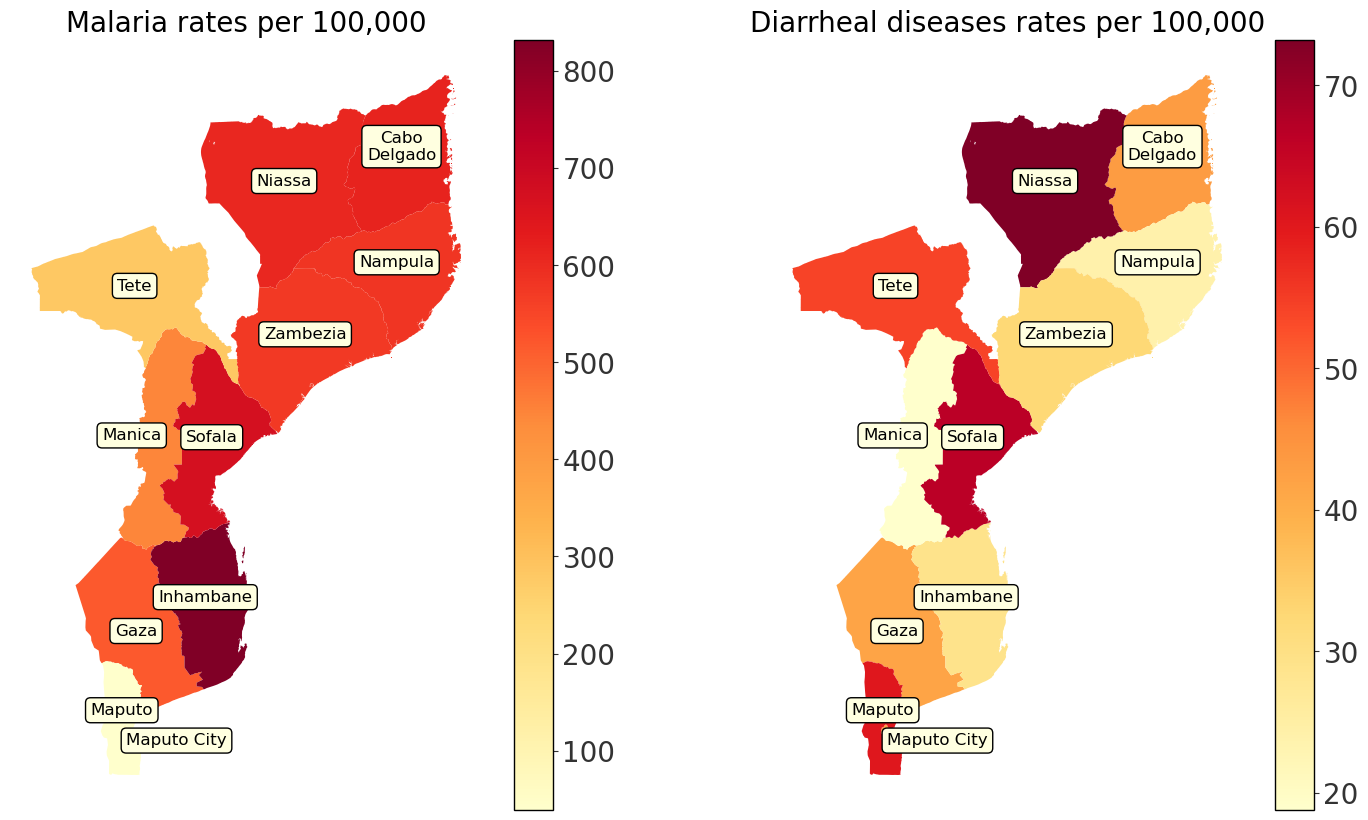

In [5]:
fp = "./data/shape_files/mf080jg3729.shp" 
shp_data = gpd.read_file(fp)
shp_data['malaria_rates'] = malaria_rates.values
shp_data['diarrhea_rates'] = diarrhea_rates.values
shp_data = shp_data.replace('Nassa','Niassa')
shp_data = shp_data.replace('Cabo Delgado','Cabo\nDelgado')

fig, axes = plt.subplots(ncols=2, figsize = (18,10))
ax0 = shp_data.plot(cmap='YlOrRd',column='malaria_rates', legend=True, ax=axes[0])
ax1 = shp_data.plot(cmap='YlOrRd',column='diarrhea_rates', legend=True, ax=axes[1])
ax0.set_title('Malaria rates per 100,000',fontsize=20)
ax1.set_title('Diarrheal diseases rates per 100,000',fontsize=20)
for ax in axes:
    for idx, row in shp_data.iterrows():
        province_name = row['name_1']
        if((province_name=='Manica')):
            ax.annotate(text=province_name, xy=row.geometry.centroid.coords[0], ha='right', fontsize=12,
                        bbox=dict(facecolor='lightyellow', edgecolor='black', boxstyle='round'))
        elif((province_name=='Maputo')):
            ax.annotate(text=province_name, xy=row.geometry.centroid.coords[0], ha='center', va='bottom', fontsize=12,
                        bbox=dict(facecolor='lightyellow', edgecolor='black', boxstyle='round'))
        elif((province_name=='Gaza')):
            ax.annotate(text=province_name, xy=row.geometry.centroid.coords[0], ha='center', va='top', fontsize=12,
                        bbox=dict(facecolor='lightyellow', edgecolor='black', boxstyle='round'))
        elif((province_name=='Maputo City')):
            ax.annotate(text=province_name, xy=row.geometry.centroid.coords[0], ha='left', va='top', fontsize=12,
                        bbox=dict(facecolor='lightyellow', edgecolor='black', boxstyle='round'))
        else:
            ax.annotate(text=province_name, xy=row.geometry.centroid.coords[0], ha='center', fontsize=12,
                        bbox=dict(facecolor='lightyellow', edgecolor='black', boxstyle='round'))
    ax.set_axis_off()

ax0.figure.axes[2].tick_params(labelsize=20)
ax1.figure.axes[3].tick_params(labelsize=20)
#plt.tight_layout()


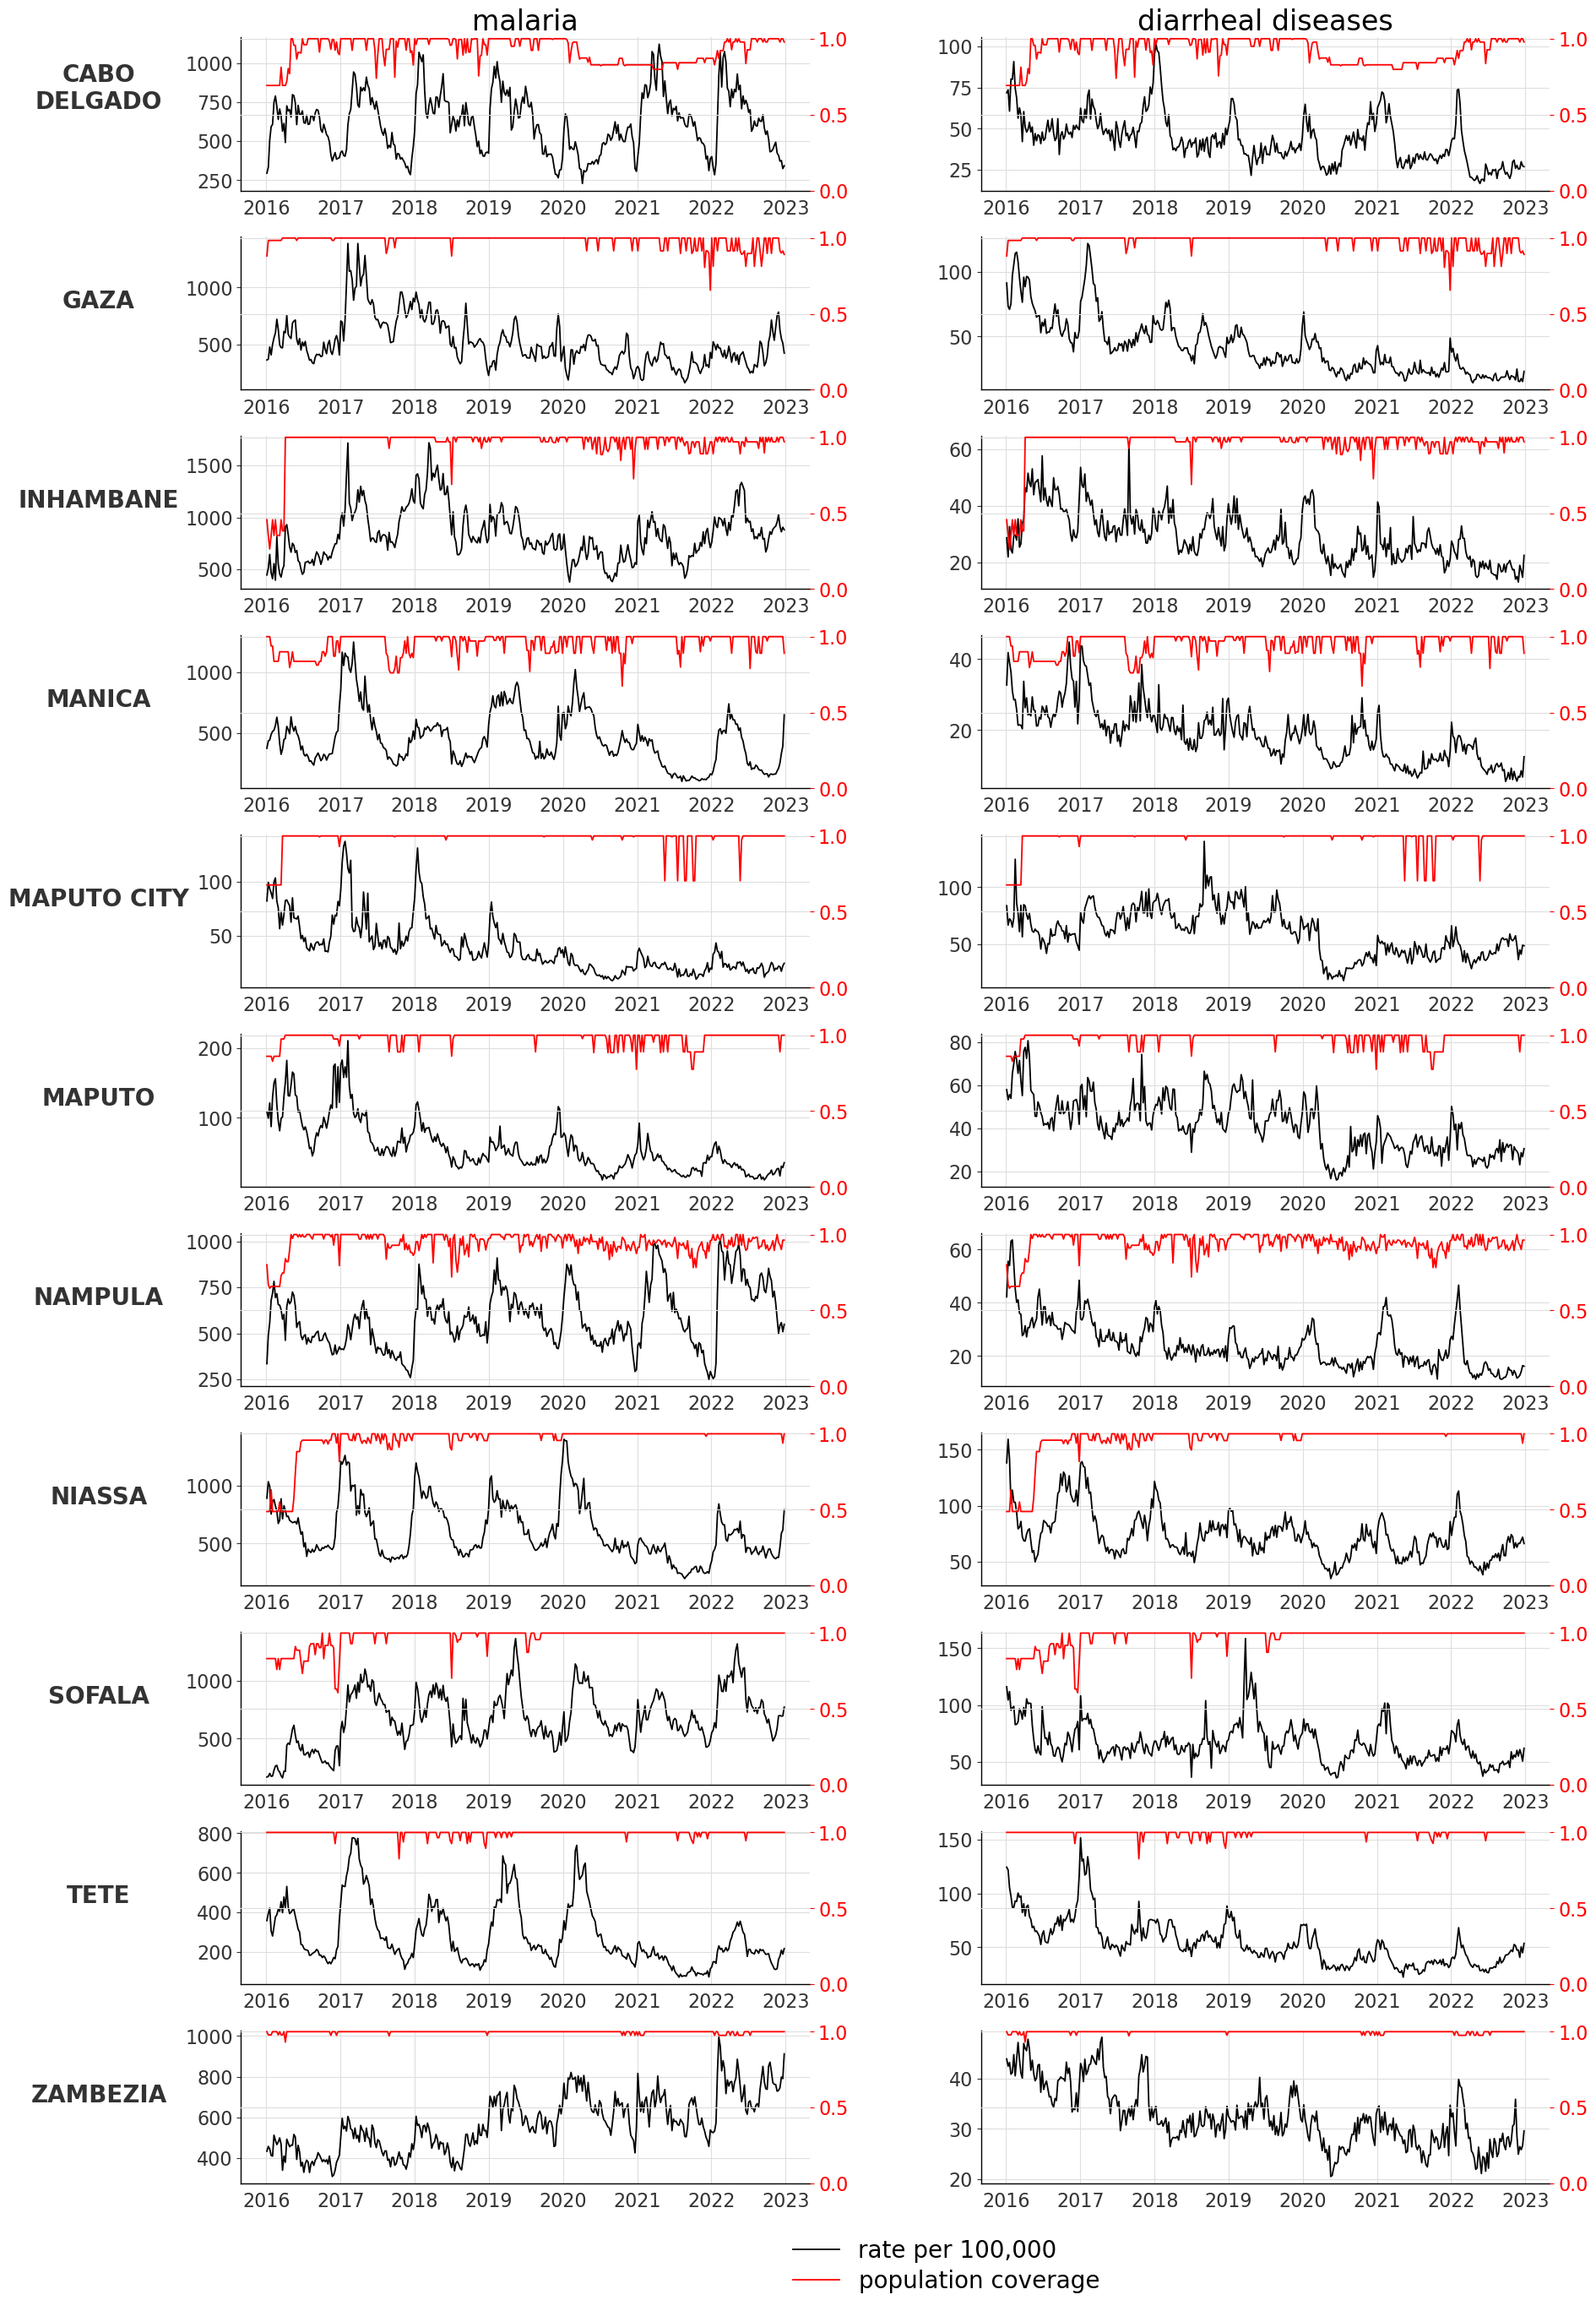

In [6]:
fig, axes = plt.subplots(nrows=len(provinces), ncols=2, figsize=(20, 3 * len(provinces)))
data_types = ['malaria','diarrhea']
for j in range(len(data_types)):
    df_rates1 = df_rates[df_rates['data']==data_types[j]]
    for i in range(len(provinces)):
        province_rates = df_rates1[df_rates1.province==provinces[i]]
        ax = axes[i,j]
        ax.plot(province_rates.date,province_rates.value,color='black',label='rate per 100,000')
        ax.tick_params(labelsize=16)
        ax.spines['left'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        province_coverage = df_coverage[provinces[i]]
        ax2 = ax.twinx() 
        ax2.plot(province_coverage,color='red',label='population coverage')
        ax2.set_ylim(0,1.01)
        ax2.tick_params(labelsize=16)
        ax2.tick_params(axis='y', colors='red')
        if(j==0):
            axes[i,j].set_ylabel(provinces2[i], rotation=0, fontsize=20)
            axes[i,j].yaxis.set_label_coords(-0.25, 0.5)

ax.legend(bbox_to_anchor=(0.15, -0.3), borderaxespad=0, title='', fontsize=20)
ax2.legend(bbox_to_anchor=(0.225, -0.5), borderaxespad=0, title='', fontsize=20)
axes[0,0].set_title('malaria',fontsize=24) 
axes[0,1].set_title('diarrheal diseases',fontsize=24) 
plt.subplots_adjust(hspace=0.3, wspace=0.3)

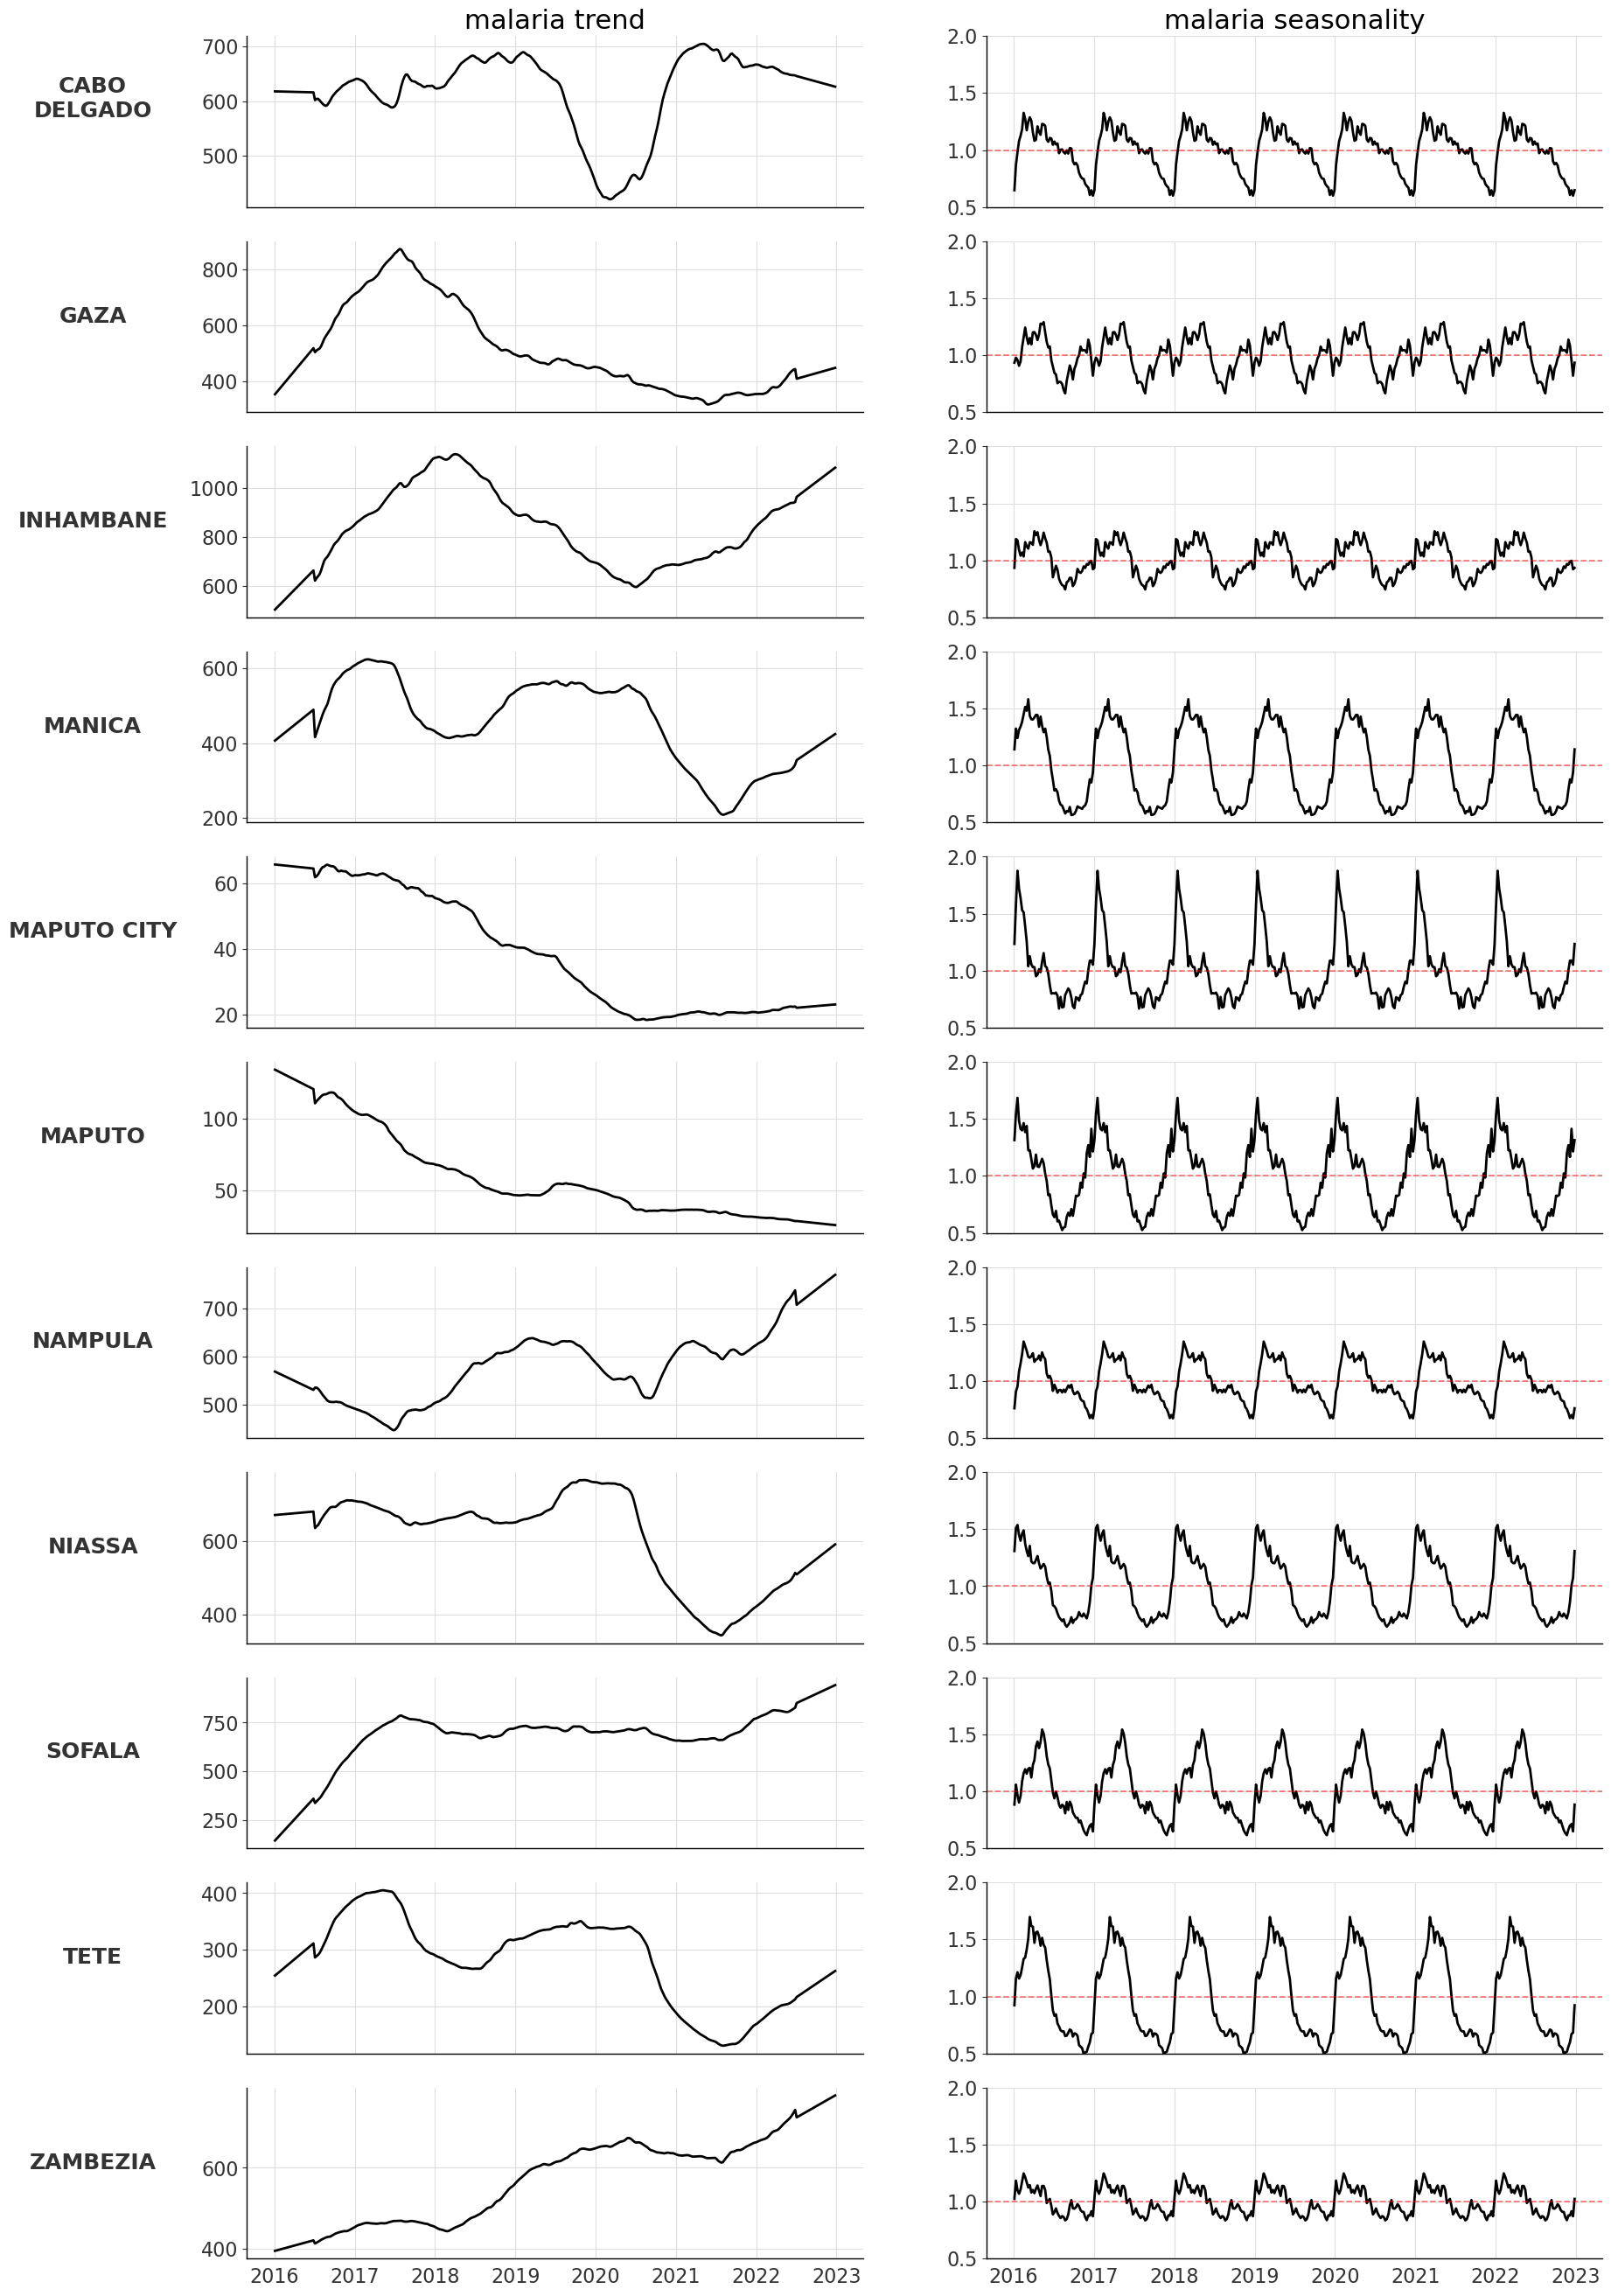

In [7]:
fig, axes = plt.subplots(nrows=len(provinces), ncols=2, figsize=(20, 3 * len(provinces)))
malaria_seasonalities = None
malaria_trends = None
for i, province in enumerate(provinces):
    ts = get_province_timeseries(df_malaria_rates_wide,province)
    (trend1, seasonality1) = extract_trend_and_seasonality(ts,model=SeasonalityMode.MULTIPLICATIVE)
    if(malaria_seasonalities is None):
        malaria_seasonalities = seasonality1
        malaria_trends = trend1
    else:
        malaria_seasonalities = malaria_seasonalities.stack(seasonality1)
        malaria_trends = malaria_trends.stack(trend1)
    trend1.plot(ax=axes[i,0],label='',color='black')
    axes[i,0].set_ylabel(provinces2[i], rotation=0, fontsize=18)
    axes[i,0].yaxis.set_label_coords(-0.25, 0.5)
    axes[i,0].set_xlabel('')
    if(i!=len(provinces)-1):
        axes[i,0].xaxis.set_ticklabels([])
    axes[i,0].tick_params(labelsize=16)
    axes[i,0].get_legend().remove()
    axes[i,0].spines['left'].set_visible(True)
    axes[i,0].spines['bottom'].set_visible(True)
    seasonality1.plot(ax=axes[i,1],label='',color='black')
    axes[i,1].get_legend().remove()
    axes[i,1].set_xlabel('')
    axes[i,1].set_ylim([0.5,2])
    axes[i,1].axhline(y=1, color='red', linestyle='--',alpha=0.5)
    if(i!=len(provinces)-1):
        axes[i,1].xaxis.set_ticklabels([])
    axes[i,1].tick_params(labelsize=16)
    axes[i,1].set_xlabel('')
    axes[i,1].spines['left'].set_visible(True)
    axes[i,1].spines['bottom'].set_visible(True)
axes[0,0].set_title('malaria trend',fontsize=22)
axes[0,1].set_title('malaria seasonality',fontsize=22)
malaria_seasonalities = malaria_seasonalities.pd_dataframe()
malaria_seasonalities.columns = provinces2
malaria_trends = malaria_trends.pd_dataframe()
malaria_trends.columns = provinces2

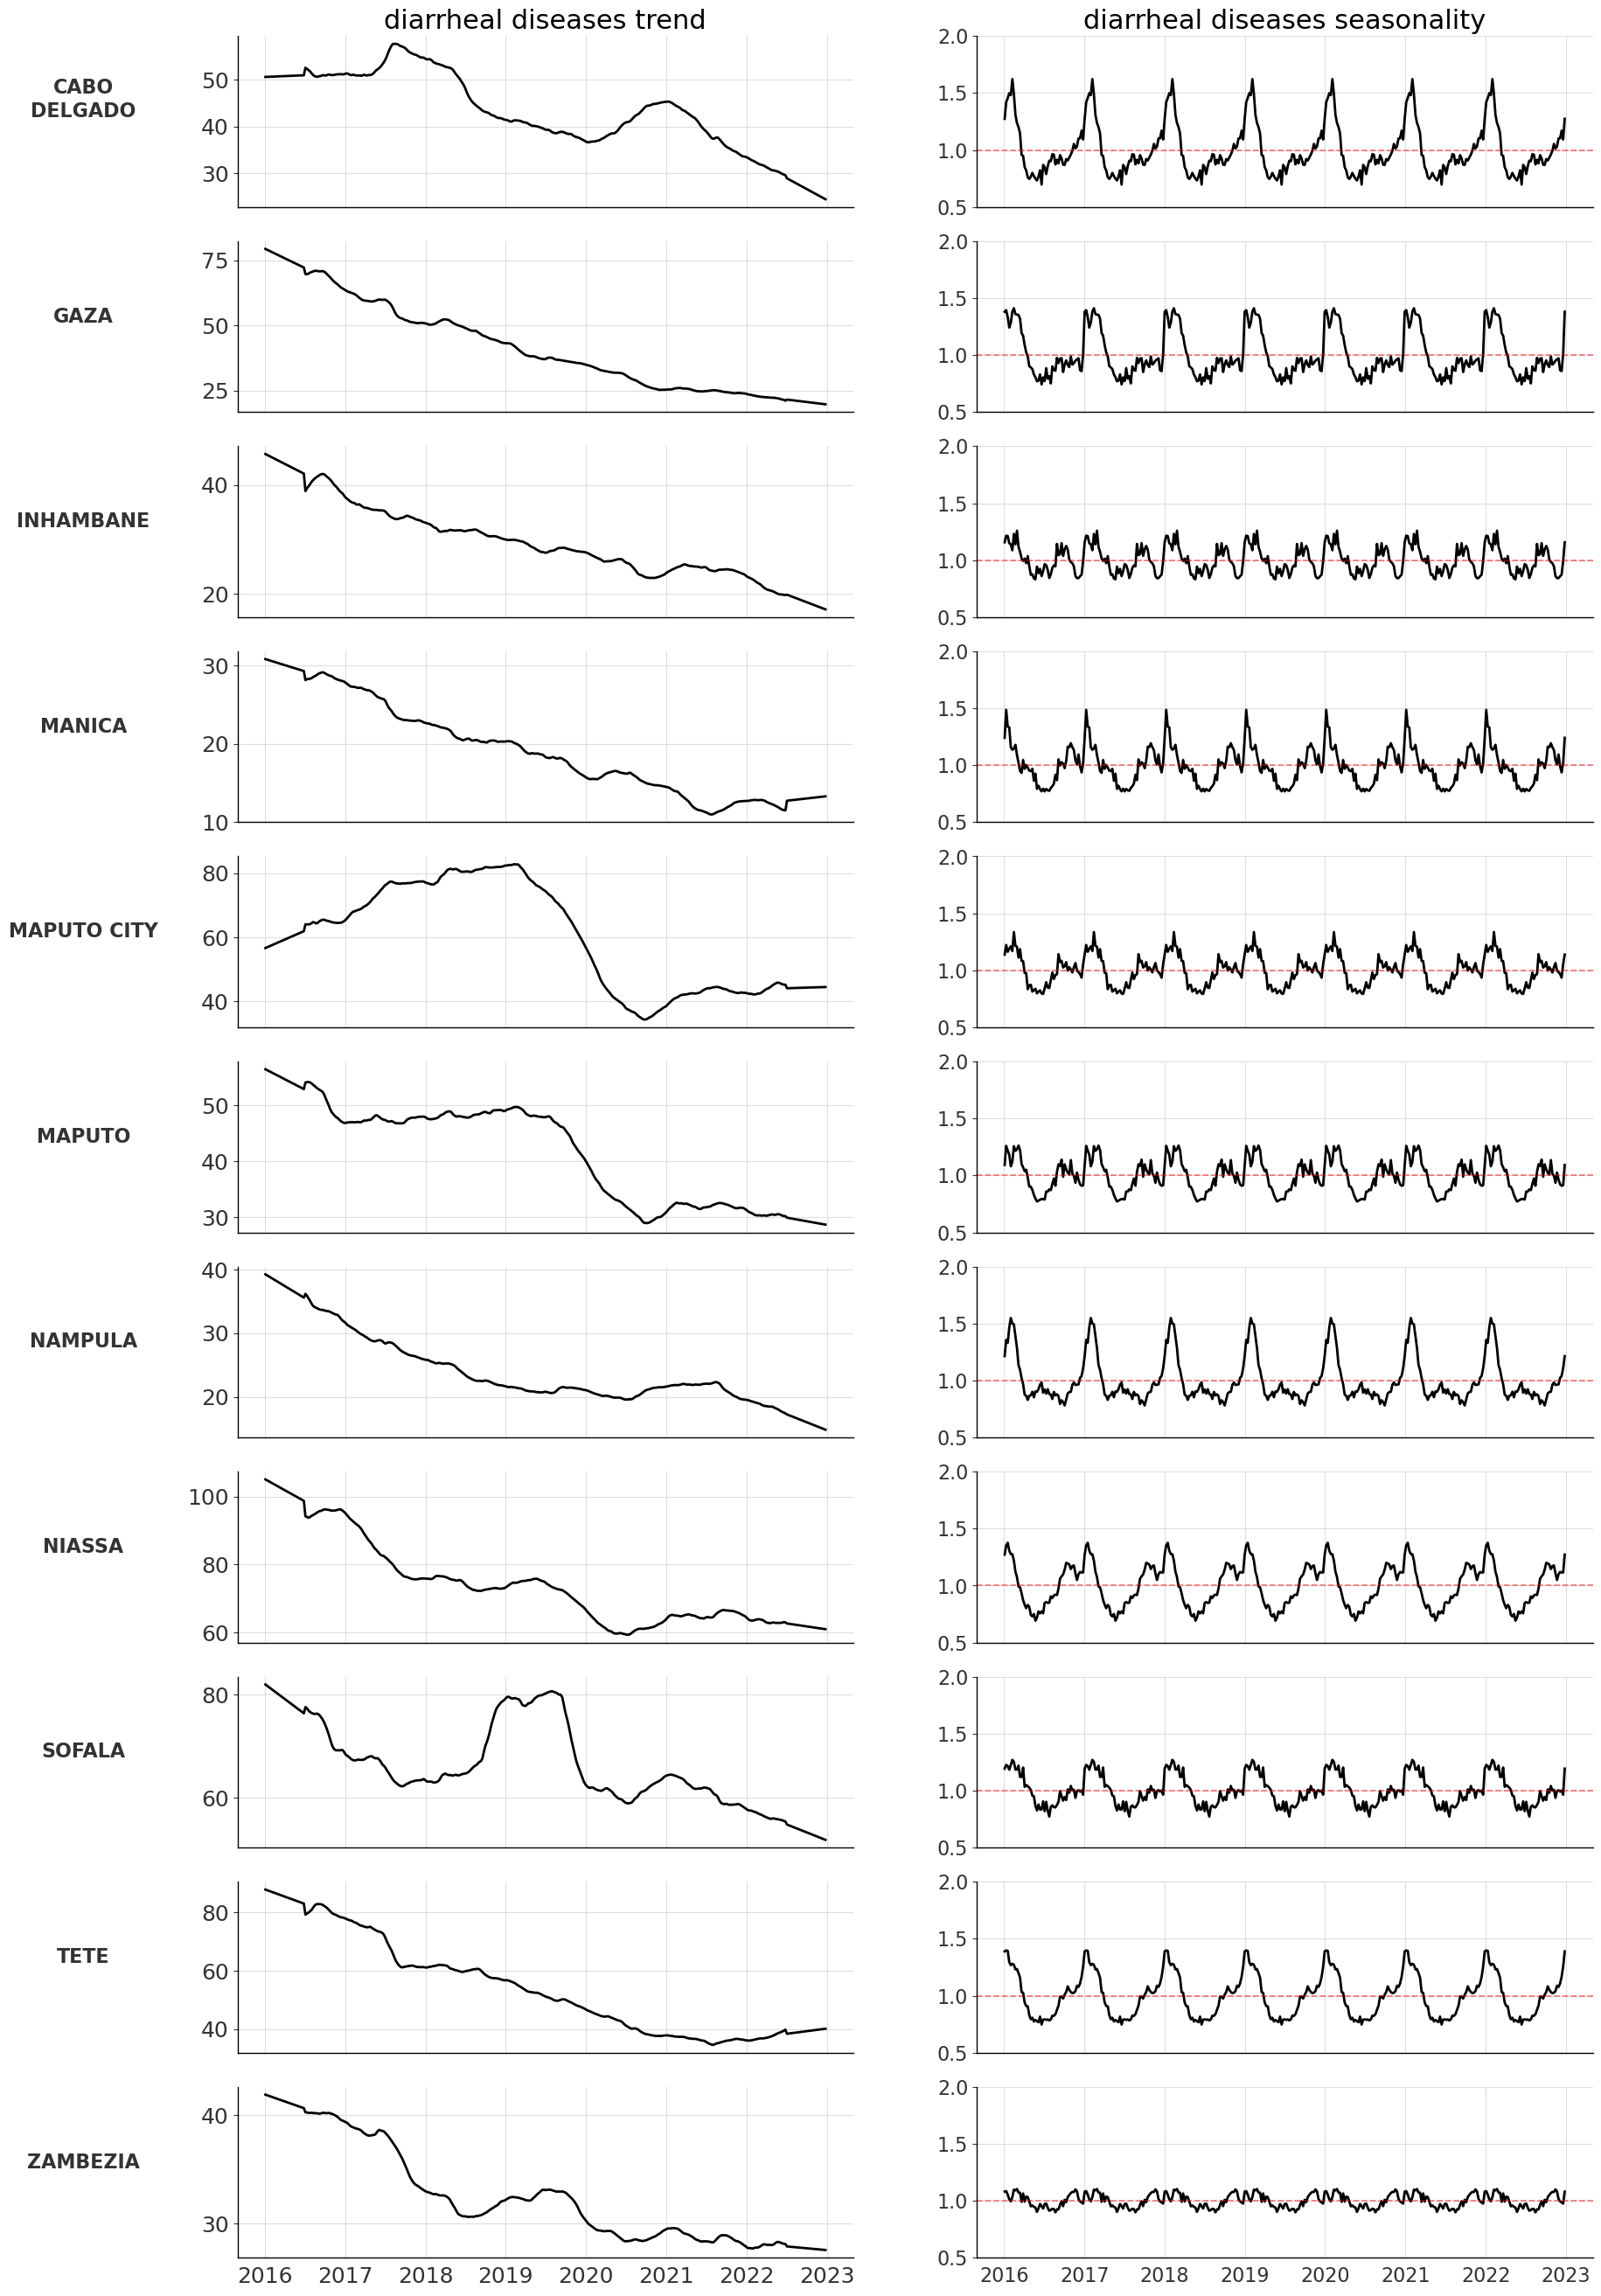

In [8]:
fig, axes = plt.subplots(nrows=len(provinces), ncols=2, figsize=(20, 3 * len(provinces)))
diarrhea_seasonalities = None
diarrhea_trends = None
for i, province in enumerate(provinces):
    ts = get_province_timeseries(df_diarrhea_rates_wide,province)
    (trend1, seasonality1) = extract_trend_and_seasonality(ts,model=SeasonalityMode.MULTIPLICATIVE)
    if(diarrhea_seasonalities is None):
        diarrhea_seasonalities = seasonality1
        diarrhea_trends = trend1
    else:
        diarrhea_seasonalities = diarrhea_seasonalities.stack(seasonality1)
        diarrhea_trends = diarrhea_trends.stack(trend1)
    trend1.plot(ax=axes[i,0],label='',color='black')
    axes[i,0].set_ylabel(provinces2[i], rotation=0, fontsize=16)
    axes[i,0].yaxis.set_label_coords(-0.25, 0.5)
    axes[i,0].set_xlabel('')
    if(i!=len(provinces)-1):
        axes[i,0].xaxis.set_ticklabels([])
    axes[i,0].tick_params(labelsize=18)
    axes[i,0].get_legend().remove()
    axes[i,0].spines['left'].set_visible(True)
    axes[i,0].spines['bottom'].set_visible(True)
    seasonality1.plot(ax=axes[i,1],label='',color='black')
    axes[i,1].get_legend().remove()
    axes[i,1].set_xlabel('')
    axes[i,1].set_ylim([0.5,2])
    axes[i,1].axhline(y=1, color='red', linestyle='--',alpha=0.5)
    if(i!=len(provinces)-1):
        axes[i,1].xaxis.set_ticklabels([])
    axes[i,1].tick_params(labelsize=16)
    axes[i,1].set_xlabel('')
    axes[i,1].spines['left'].set_visible(True)
    axes[i,1].spines['bottom'].set_visible(True)
axes[0,0].set_title('diarrheal diseases trend',fontsize=22)
axes[0,1].set_title('diarrheal diseases seasonality',fontsize=22)
diarrhea_seasonalities = diarrhea_seasonalities.pd_dataframe()
diarrhea_seasonalities.columns = provinces2
diarrhea_trends = diarrhea_trends.pd_dataframe()
diarrhea_trends.columns = provinces2

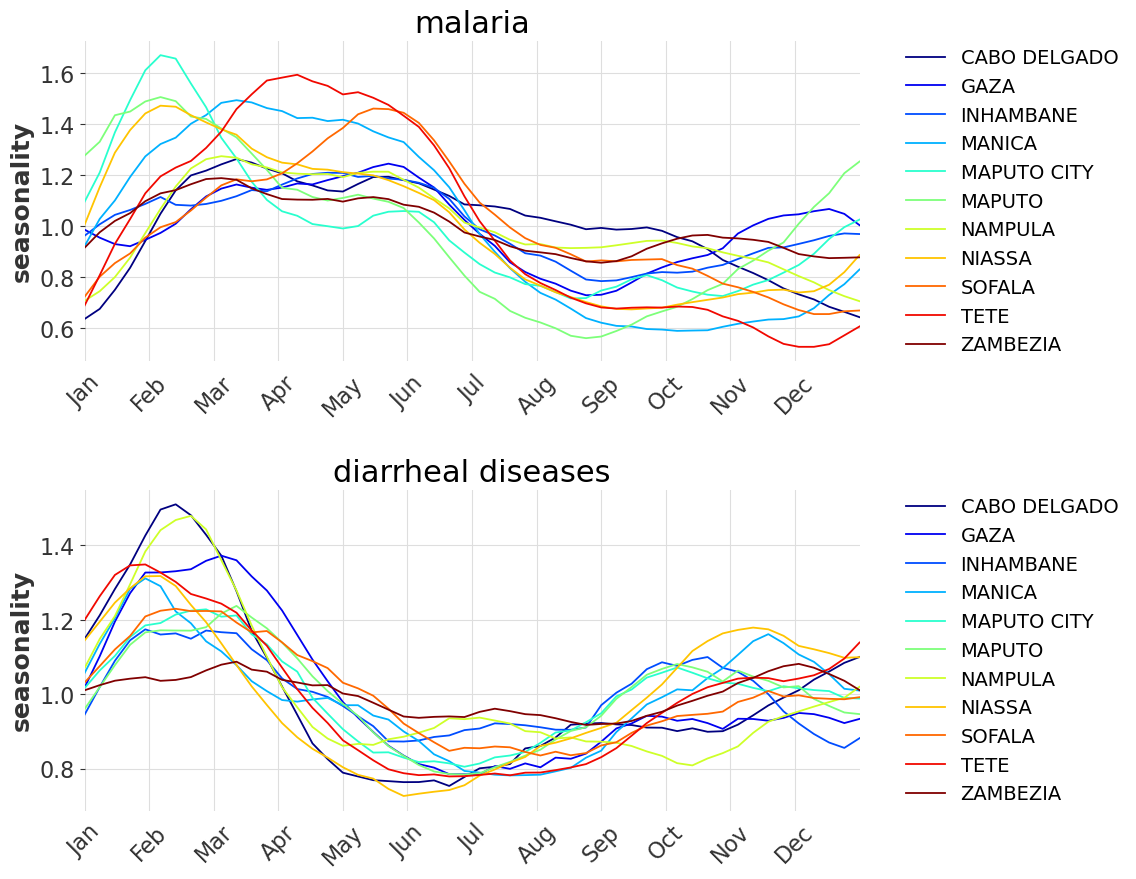

In [9]:
line_colors = plt.cm.jet(np.linspace(0,1,len(provinces)))
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,10))

s1 = malaria_seasonalities.rolling(window=5).mean().iloc[52:104,:]
xind = s1.index-np.min(s1.index)
xind = xind/np.max(xind)
month_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
for i in range(len(provinces)):
    axes[0].plot(xind,s1.iloc[:,i],color=line_colors[i],label=provinces[i])
axes[0].legend(bbox_to_anchor=(1.05, 1), borderaxespad=0, title='', fontsize=14)
axes[0].tick_params(labelsize=16)
axes[0].set_xlabel('')
axes[0].set_ylabel('seasonality',fontsize=18)
axes[0].set_title('malaria',fontsize=22)
axes[0].set_xticks(np.arange(0, 1 , 1/12))
axes[0].set_xticklabels(month_labels,rotation=45)
axes[0].set_xlim([0,1])

s2 = diarrhea_seasonalities.rolling(window=5).mean().iloc[52:104,:]
for i in range(len(provinces)):
    axes[1].plot(xind,s2.iloc[:,i],color=line_colors[i],label=provinces[i])
axes[1].legend(bbox_to_anchor=(1.05, 1), borderaxespad=0, title='', fontsize=14)
axes[1].tick_params(labelsize=16)
axes[1].set_xlabel('')
axes[1].set_ylabel('seasonality',fontsize=18)
axes[1].set_title('diarrheal diseases',fontsize=22)
axes[1].set_xticks(np.arange(0, 1 , 1/12))
axes[1].set_xticklabels(month_labels,rotation=45)
axes[1].set_xlim([0,1])
plt.subplots_adjust(hspace=0.4, wspace=0.3)

In [10]:
print('malaria peak seasonality:')
print(s1.idxmax())

print('diarrhea peak seasonality:')
print(s2.idxmax())

malaria peak seasonality:
CABO\nDELGADO   2017-03-13
GAZA            2017-05-22
INHAMBANE       2017-04-24
MANICA          2017-03-13
MAPUTO CITY     2017-02-06
MAPUTO          2017-02-06
NAMPULA         2017-03-06
NIASSA          2017-02-06
SOFALA          2017-05-15
TETE            2017-04-10
ZAMBEZIA        2017-03-06
dtype: datetime64[ns]
diarrhea peak seasonality:
CABO\nDELGADO   2017-02-13
GAZA            2017-03-06
INHAMBANE       2017-01-30
MANICA          2017-01-30
MAPUTO CITY     2017-02-27
MAPUTO          2017-03-13
NAMPULA         2017-02-20
NIASSA          2017-02-06
SOFALA          2017-02-13
TETE            2017-01-30
ZAMBEZIA        2017-03-13
dtype: datetime64[ns]


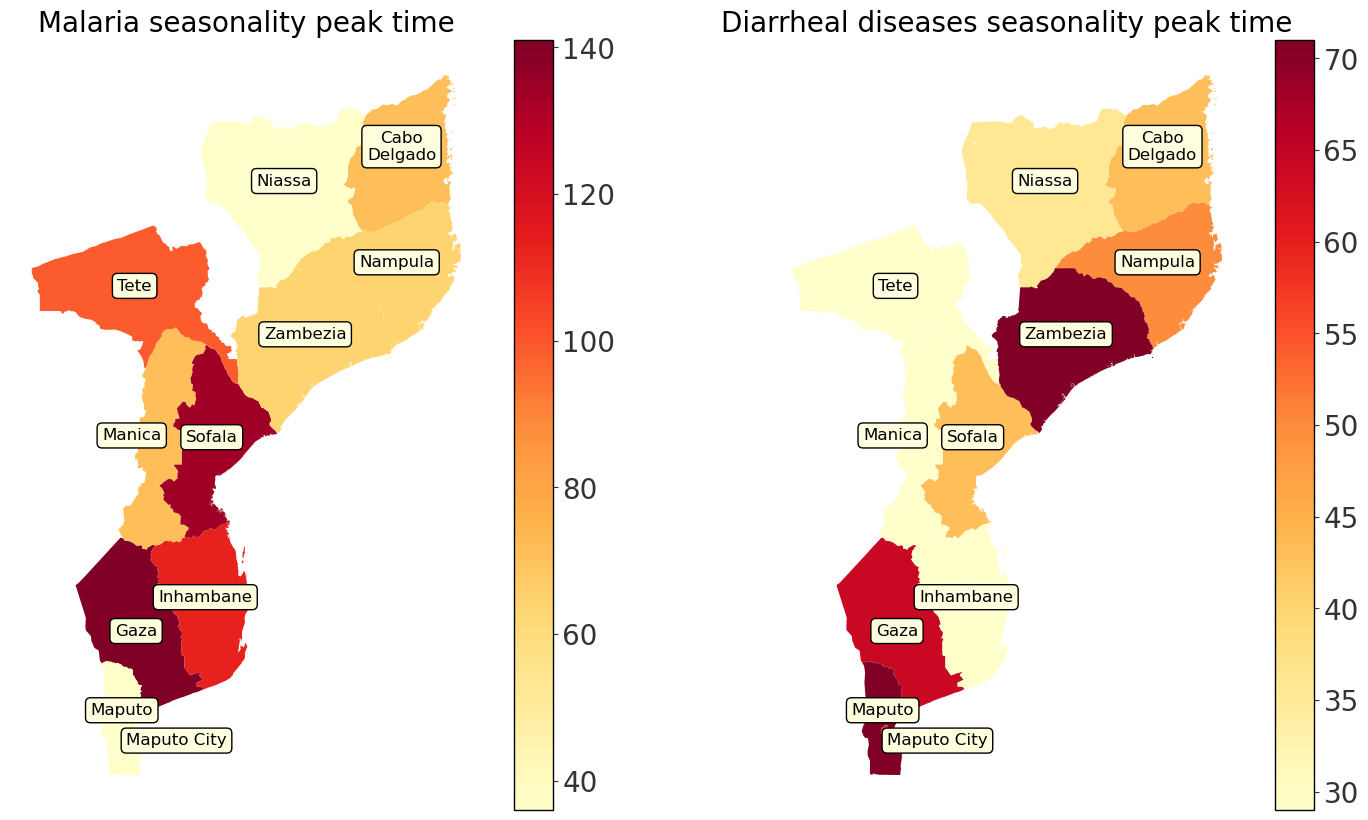

In [11]:
s1_time = (s1.idxmax()-pd.Timestamp('2017-01-01')) / pd.Timedelta(days=1)
s2_time = (s2.idxmax()-pd.Timestamp('2017-01-01')) / pd.Timedelta(days=1)
shp_data['malaria_seasonal_timing'] = s1_time.values
shp_data['diarrhea_seasonal_timing'] = s2_time.values
fig, axes = plt.subplots(ncols=2, figsize = (18,10))
ax0 = shp_data.plot(cmap='YlOrRd',column='malaria_seasonal_timing', legend=True, ax=axes[0])
ax1 = shp_data.plot(cmap='YlOrRd',column='diarrhea_seasonal_timing', legend=True, ax=axes[1])
ax0.set_title('Malaria seasonality peak time',fontsize=20)
ax1.set_title('Diarrheal diseases seasonality peak time',fontsize=20)
for ax in axes:
    for idx, row in shp_data.iterrows():
        province_name = row['name_1']
        if((province_name=='Manica')):
            ax.annotate(text=province_name, xy=row.geometry.centroid.coords[0], ha='right', fontsize=12,
                        bbox=dict(facecolor='lightyellow', edgecolor='black', boxstyle='round'))
        elif((province_name=='Maputo')):
            ax.annotate(text=province_name, xy=row.geometry.centroid.coords[0], ha='center', va='bottom', fontsize=12,
                        bbox=dict(facecolor='lightyellow', edgecolor='black', boxstyle='round'))
        elif((province_name=='Gaza')):
            ax.annotate(text=province_name, xy=row.geometry.centroid.coords[0], ha='center', va='top', fontsize=12,
                        bbox=dict(facecolor='lightyellow', edgecolor='black', boxstyle='round'))
        elif((province_name=='Maputo City')):
            ax.annotate(text=province_name, xy=row.geometry.centroid.coords[0], ha='left', va='top', fontsize=12,
                        bbox=dict(facecolor='lightyellow', edgecolor='black', boxstyle='round'))
        else:
            ax.annotate(text=province_name, xy=row.geometry.centroid.coords[0], ha='center', fontsize=12,
                        bbox=dict(facecolor='lightyellow', edgecolor='black', boxstyle='round'))
    ax.set_axis_off()

ax0.figure.axes[2].tick_params(labelsize=20)
ax1.figure.axes[3].tick_params(labelsize=20)

In [12]:
print('malaria max seasonality:')
print(s1.max())

print('\ndiarrhea max seasonality:')
print(s2.max())

malaria max seasonality:
CABO\nDELGADO    1.262012
GAZA             1.243798
INHAMBANE        1.208127
MANICA           1.492599
MAPUTO CITY      1.669228
MAPUTO           1.504863
NAMPULA          1.273110
NIASSA           1.471106
SOFALA           1.459825
TETE             1.592368
ZAMBEZIA         1.187100
dtype: float64

diarrhea max seasonality:
CABO\nDELGADO    1.510126
GAZA             1.372177
INHAMBANE        1.174268
MANICA           1.311265
MAPUTO CITY      1.227964
MAPUTO           1.237236
NAMPULA          1.479123
NIASSA           1.317444
SOFALA           1.229498
TETE             1.348600
ZAMBEZIA         1.087304
dtype: float64


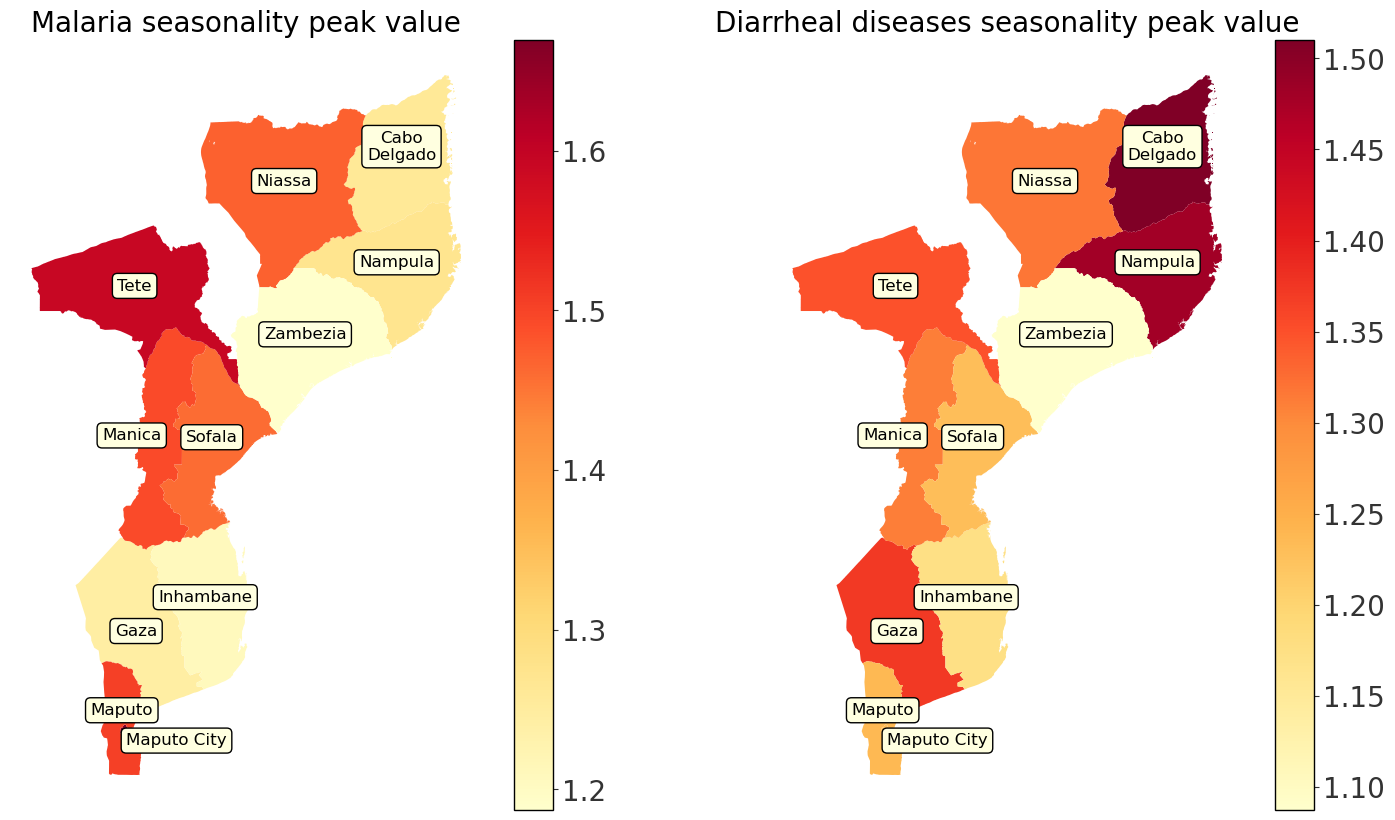

In [13]:
shp_data['malaria_seasonal_max'] = s1.max().values
shp_data['diarrhea_seasonal_max'] = s2.max().values
fig, axes = plt.subplots(ncols=2, figsize = (18,10))
ax0 = shp_data.plot(cmap='YlOrRd',column='malaria_seasonal_max', legend=True, ax=axes[0])
ax1 = shp_data.plot(cmap='YlOrRd',column='diarrhea_seasonal_max', legend=True, ax=axes[1]) #legend_kwds={"label": ""},
ax0.set_title('Malaria seasonality peak value',fontsize=20)
ax1.set_title('Diarrheal diseases seasonality peak value',fontsize=20)
for ax in axes:
    for idx, row in shp_data.iterrows():
        province_name = row['name_1']
        if((province_name=='Manica')):
            ax.annotate(text=province_name, xy=row.geometry.centroid.coords[0], ha='right', fontsize=12,
                        bbox=dict(facecolor='lightyellow', edgecolor='black', boxstyle='round'))
        elif((province_name=='Maputo')):
            ax.annotate(text=province_name, xy=row.geometry.centroid.coords[0], ha='center', va='bottom', fontsize=12,
                        bbox=dict(facecolor='lightyellow', edgecolor='black', boxstyle='round'))
        elif((province_name=='Gaza')):
            ax.annotate(text=province_name, xy=row.geometry.centroid.coords[0], ha='center', va='top', fontsize=12,
                        bbox=dict(facecolor='lightyellow', edgecolor='black', boxstyle='round'))
        elif((province_name=='Maputo City')):
            ax.annotate(text=province_name, xy=row.geometry.centroid.coords[0], ha='left', va='top', fontsize=12,
                        bbox=dict(facecolor='lightyellow', edgecolor='black', boxstyle='round'))
        else:
            ax.annotate(text=province_name, xy=row.geometry.centroid.coords[0], ha='center', fontsize=12,
                        bbox=dict(facecolor='lightyellow', edgecolor='black', boxstyle='round'))
    ax.set_axis_off()

ax0.figure.axes[2].tick_params(labelsize=20)
ax1.figure.axes[3].tick_params(labelsize=20)

In [14]:
def calculate_and_plot_historical_means(df, start_year, start_week, seasons, forecast_horizons, window):

    df_metrics = pd.DataFrame(columns=['province','model','horizon','season','metric','value','data'])

    model = 'Historical Expectance'
    years = [2018,2019,2020,2021,2022] #list(set(df.date.dt.year))
    ylims = [1600, 150]
    weeks = range(0,53)
    provinces = df.province.unique()
    data_types = df.data.unique()
    fig, axes = plt.subplots(nrows=len(provinces), ncols=len(data_types), figsize=(20,4*len(provinces)))

    for j,data_type in enumerate(data_types):
        df_data = df[df.data == data_type].drop(columns=["data"])
        for i,province in enumerate(provinces):
            df_province = df_data[df_data.province == province].drop(columns=["province"])
            df_province['his_mean'] = np.nan 
            df_year = df_province.date.dt.year
            df_week = (df_province.date.dt.dayofyear/7+1).astype('int')
            for y in years:
                if((y<start_year)) :
                        continue
                for w in weeks:
                    if((y==start_year) & (w<start_week)) :
                        continue
                    index = df_province[(df_year==y) & (df_week==w)].index
                    df_sel = df_province[(df_year<=y-1) & (df_year>=y-window) & (df_week==w)]
                    df_province.loc[index,'his_mean'] = df_sel['value'].mean()
                index = df_province[(df_year==y) & (df_week==53)].index
                if(len(index) > 0) :
                    df_sel = df_province[(df_year<=y-1) & (df_year>=y-window) & (df_week>=52)]
                    df_province.loc[index,'his_mean'] = df_sel['value'].mean()

            rmse_val = np.sqrt(np.mean((df_province.value-df_province.his_mean)**2))
            mape_val = 100*np.mean(np.abs((df_province.value-df_province.his_mean)/df_province.value))
            smape_val = 200*np.mean(np.abs((df_province.value-df_province.his_mean)/(df_province.value+df_province.his_mean)))
            wis_val = -1 #np.nan
            season = 'all'
        
            for _, horizon in enumerate(forecast_horizons):
                df_metrics.loc[len(df_metrics.index)] = [province, model, horizon, season, 'RMSE', rmse_val, data_type]
                df_metrics.loc[len(df_metrics.index)] = [province, model, horizon, season, 'MAPE', mape_val, data_type]
                df_metrics.loc[len(df_metrics.index)] = [province, model, horizon, season, 'SMAPE', smape_val, data_type]
                df_metrics.loc[len(df_metrics.index)] = [province, model, horizon, season, 'WIS', wis_val, data_type]

            for _, season in enumerate(seasons):
                sel_index = df_province.index[(df_province.date>=seasons[season][0]) & (df_province.date<=seasons[season][1])]
                rmse_val_year = np.sqrt(np.mean((df_province.value[sel_index]-df_province.his_mean[sel_index])**2))
                mape_val_year = 100*np.mean(np.abs((df_province.value[sel_index]-df_province.his_mean[sel_index])/df_province.value[sel_index]))
                smape_val_year = 200*np.mean(np.abs((df_province.value[sel_index]-df_province.his_mean[sel_index])/(df_province.value[sel_index]+df_province.his_mean[sel_index])))
                for _, horizon in enumerate(forecast_horizons):
                    df_metrics.loc[len(df_metrics.index)] = [province, model, horizon, season, 'RMSE', rmse_val_year, data_type]
                    df_metrics.loc[len(df_metrics.index)] = [province, model, horizon, season, 'MAPE', mape_val_year, data_type]
                    df_metrics.loc[len(df_metrics.index)] = [province, model, horizon, season, 'SMAPE', smape_val_year, data_type]
                    df_metrics.loc[len(df_metrics.index)] = [province, model, horizon, season, 'WIS', wis_val, data_type]

            axes[i,j].plot(df_province.date,df_province.value,color='black',linewidth=3,label='observed incidence per 100,000')
            axes[i,j].plot(df_province.date,df_province.his_mean,color='red',linewidth=2,linestyle='dashed',label='historical expectance')           

            axes[i,j].set_ylim(bottom=0) #,top=ylims[j])
            axes[i,j].tick_params(labelsize=18)
            axes[i,j].spines['left'].set_visible(True)
            axes[i,j].spines['bottom'].set_visible(True)
            axes[i,j].set_title("")

            if(j==0):
                axes[i,j].set_ylabel(provinces[i], rotation=0, fontsize=20)
                axes[i,j].yaxis.set_label_coords(-0.275, 0.5)
            if(i<len(provinces)-1):
                axes[i,j].set_xticklabels([])

    axes[i,j].legend(bbox_to_anchor=(0.15, -0.3), borderaxespad=0, title='', fontsize=20)
    axes[0,0].set_title('malaria',fontsize=24)
    axes[0,1].set_title('diarrheal diseases',fontsize=24)
    return (df_metrics)


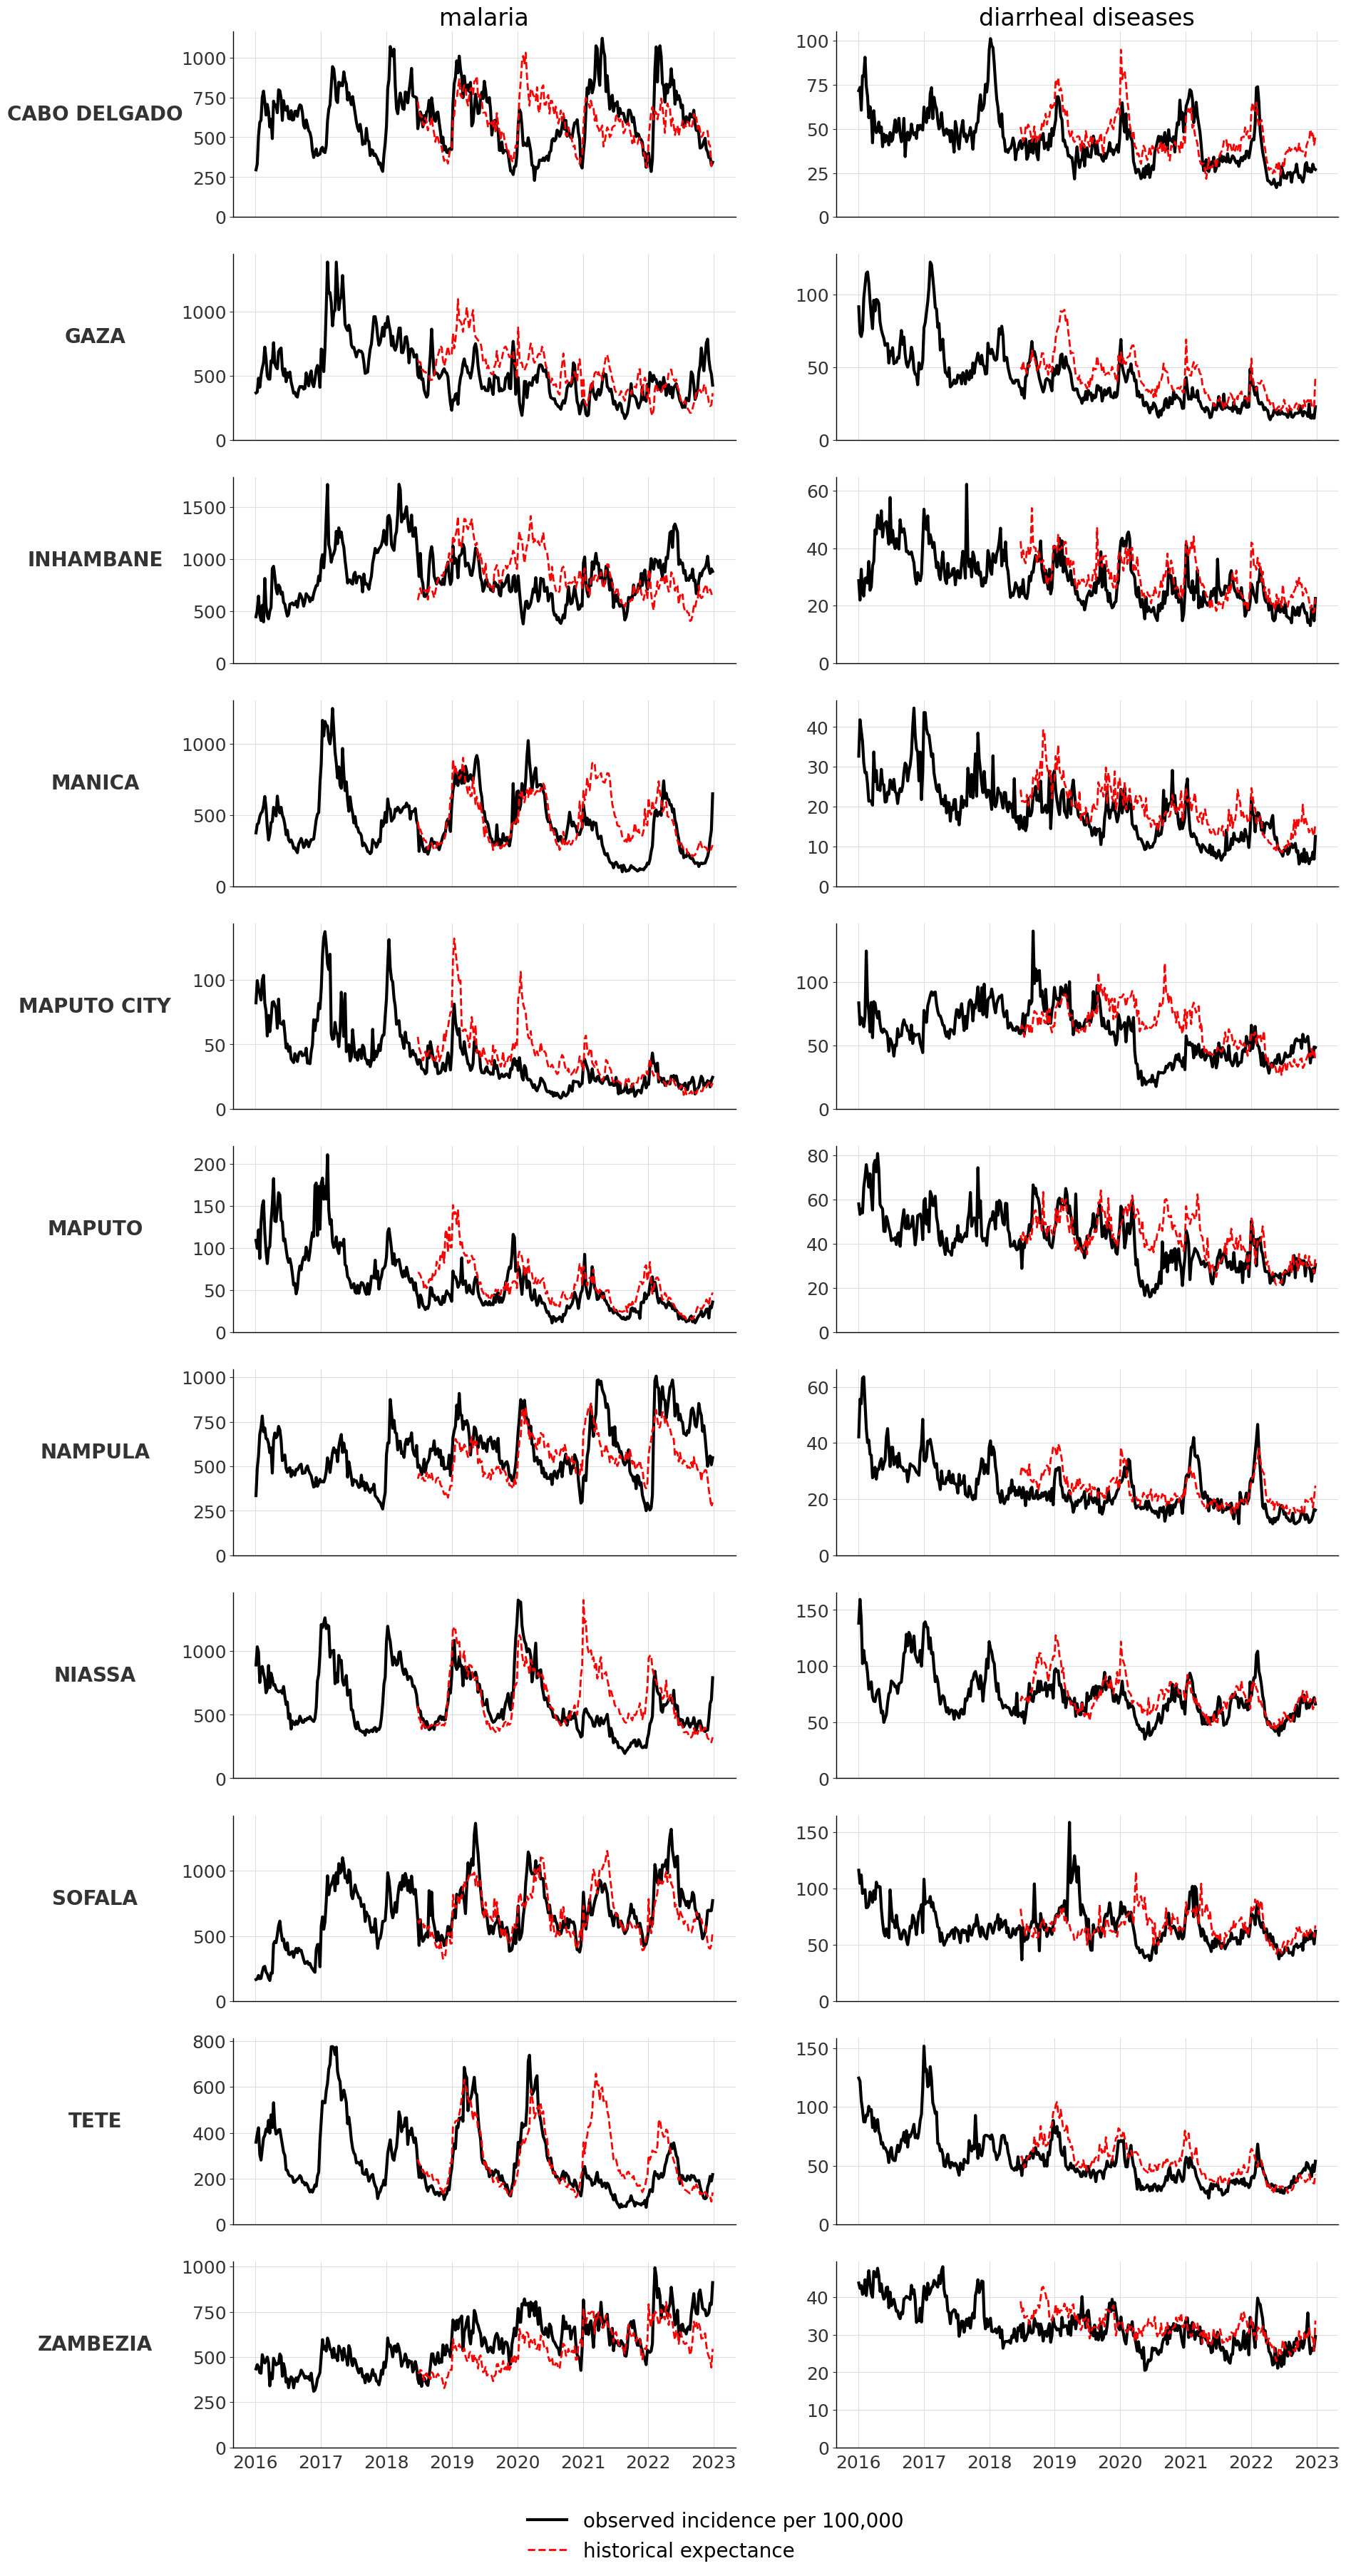

In [15]:
start_year = 2018
start_week = 26
seasons = {
'2019' : [pd.Timestamp('2019-01-01'),pd.Timestamp('2019-12-31')],
'2020' : [pd.Timestamp('2020-01-01'),pd.Timestamp('2020-12-31')],
'2021' : [pd.Timestamp('2021-01-01'),pd.Timestamp('2021-12-31')],
'2022' : [pd.Timestamp('2022-01-01'),pd.Timestamp('2022-12-31')],
}
forecast_horizons = [2, 4, 8, 16] 
df_rates1 = df_rates.copy()
df_rates1 = df_rates1.replace('Cabo Delgado','Cabo\nDelgado')
df_metrics_his_mean =  calculate_and_plot_historical_means(df_rates1, start_year, start_week, seasons, forecast_horizons, window=2)


In [16]:
df_forecasts = pd.DataFrame(columns=['date','province','series','value','data'])
forecast_horizons = [2, 4, 8, 16] 
model = 'WIS-Weighted Ensemble' #'Mean Ensemble' #
date = '230624' 
data_types = ["malaria", "diarrhea"]

df = pd.DataFrame({'date':df_rates['date'], 'province': df_rates['province'],'series': 'observed incidence per 100,000',
                    'value': df_rates['value'], 'data':df_rates['data']})
df_forecasts = pd.concat([df_forecasts, df])

for data_type in data_types:
    results_fname = "{}/{}/pred_results_{}_all_models.pkl".format(results_folder, date, data_type)
    with open(results_fname, 'rb') as f:
            pred_results = pickle.load(f)

    for province in provinces0:
        for horizon in forecast_horizons:
            key = province + "_" +model +"_" + str(horizon)
            pred = pred_results[key]
            df = pd.DataFrame({'date':pred.time_index.values, 'province': province,
                               'series': str(model) + ': forecast_horizon='+str(horizon), 
                               'value':pred.quantile_df(0.5).clip(lower=0).iloc[:,0].values, 'data':data_type})
            df_forecasts = pd.concat([df_forecasts, df])

df_forecasts = df_forecasts.replace('MAPUTO CIDADE','MAPUTO CITY')
df_forecasts = df_forecasts.replace('MAPUTO PROVINCIA','MAPUTO')

C:\Users\ry2460\AppData\Local\Temp\ipykernel_8052\787605068.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_forecasts = pd.concat([df_forecasts, df])


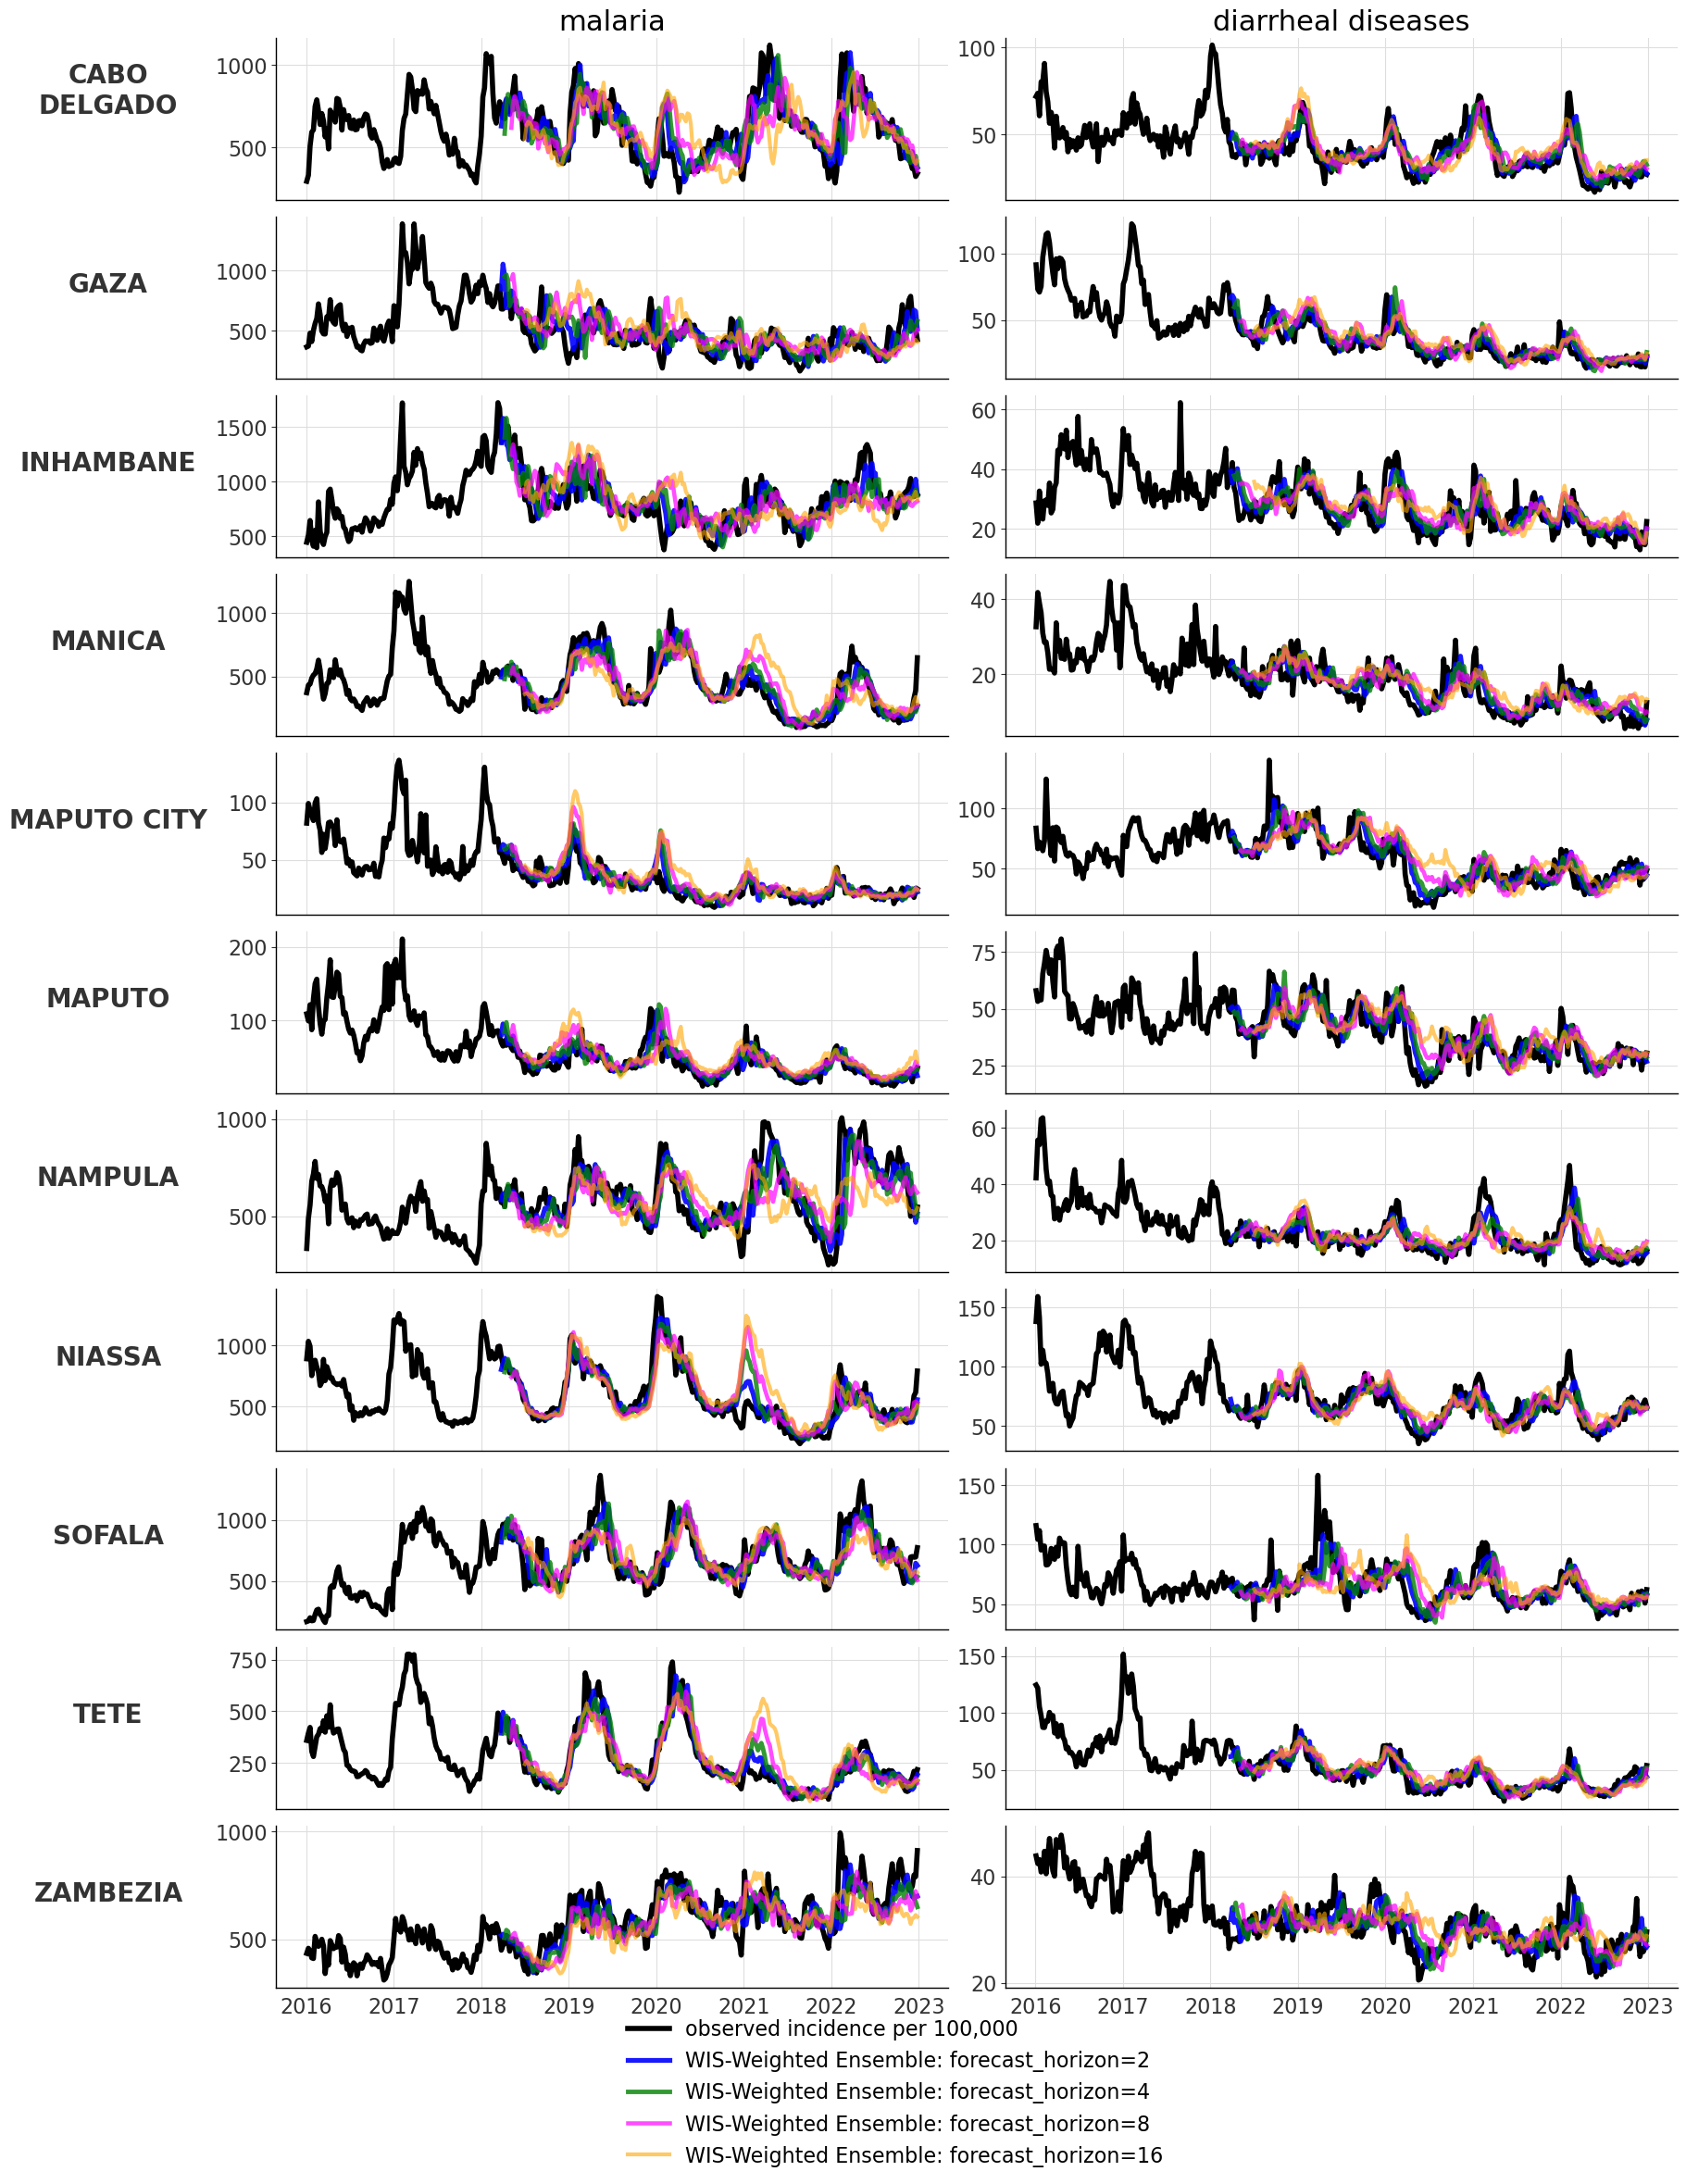

In [17]:
g = sns.FacetGrid(df_forecasts, col="data", row='province', hue='series', height=2, aspect=5, sharey=False,  palette="Set1")
g = g.map(sns.lineplot, "date", "value", linewidth=3, alpha=0.8)
g.set_axis_labels(x_var="week", y_var="incidence per 1e5")

vals = df_forecasts.series.unique()
colors = ['black','blue','green','magenta','orange']
color_dict = {}
line_dict = {}
alpha_dict = {}
for i,val in enumerate(vals):
    color_dict[val] = colors[i]
    line_dict[val] = 4-i*0.25
    alpha_dict[val] = 1-i*0.1
# Iterate through each subplot and set alpha for each line
for i, row in enumerate(g.axes):
    row[0].set_ylabel(provinces2[i], rotation=0, fontsize=20)
    row[0].yaxis.set_label_coords(-0.25, 0.5)
    for j, ax in enumerate(row):
        ax.tick_params(labelsize=16)
        lines = ax.get_lines()
        #ax.set_title(provinces[i])
        ax.set_title('')
        for k, line in enumerate(lines):
            series = line.get_label()
            line.set_color(color_dict.get(series, 'black'))
            line.set_linewidth(line_dict.get(series, 4))
            line.set_alpha(alpha_dict.get(series, 1))

g.axes[0,0].set_title('malaria',fontsize=22)
g.axes[0,1].set_title('diarrheal diseases',fontsize=22)
g.axes[len(provinces)-1,0].set_xlabel('')
g.axes[len(provinces)-1,1].set_xlabel('')
plt.tight_layout()
g.add_legend(bbox_to_anchor=(0.55, -0.03), borderaxespad=0, title='', fontsize=16)
plt.show()

In [18]:
date = '230624' 
results_dir = "{}/{}".format(results_folder,date)
df_metrics_malaria = pd.read_csv("{}/metrics_{}.csv".format(results_dir, 'malaria')) 
df_metrics_diarrhea = pd.read_csv("{}/metrics_{}.csv".format(results_dir, 'diarrhea')) 
df_metrics_malaria['data'] = 'malaria'
df_metrics_diarrhea['data'] = 'diarrhea'
df_metrics = pd.concat([df_metrics_malaria,df_metrics_diarrhea])
df_metrics = df_metrics.replace('rmse','RMSE')
df_metrics = df_metrics.replace('mape','MAPE')
df_metrics = df_metrics.replace('smape','SMAPE')
df_metrics = df_metrics.replace('wis','WIS')
df_metrics = df_metrics.replace('MAPUTO CIDADE','MAPUTO CITY')
df_metrics = df_metrics.replace('MAPUTO PROVINCIA','MAPUTO')
#df_metrics
df_malaria_var_per_province = df_malaria_rates.groupby('province')['value'].var()
df_malaria_mean_per_province  = df_malaria_rates.groupby('province')['value'].mean()
df_malaria_cv_per_province  = np.sqrt(df_malaria_var_per_province)/df_malaria_mean_per_province
df_diarrhea_var_per_province = df_diarrhea_rates.groupby('province')['value'].var()
df_diarrhea_mean_per_province  = df_diarrhea_rates.groupby('province')['value'].mean()
df_diarrhea_cv_per_province  = np.sqrt(df_diarrhea_var_per_province)/df_diarrhea_mean_per_province

C:\Users\ry2460\AppData\Local\Temp\ipykernel_8052\182146702.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_metrics_sel['horizon'] = df_metrics_sel['horizon'].astype(str)
C:\Users\ry2460\AppData\Local\Temp\ipykernel_8052\182146702.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[j].set_xticklabels(provinces,rotation=45)
C:\Users\ry2460\AppData\Local\Temp\ipykernel_8052\182146702.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[j].set_xticklabels(provinces,rotation=45)


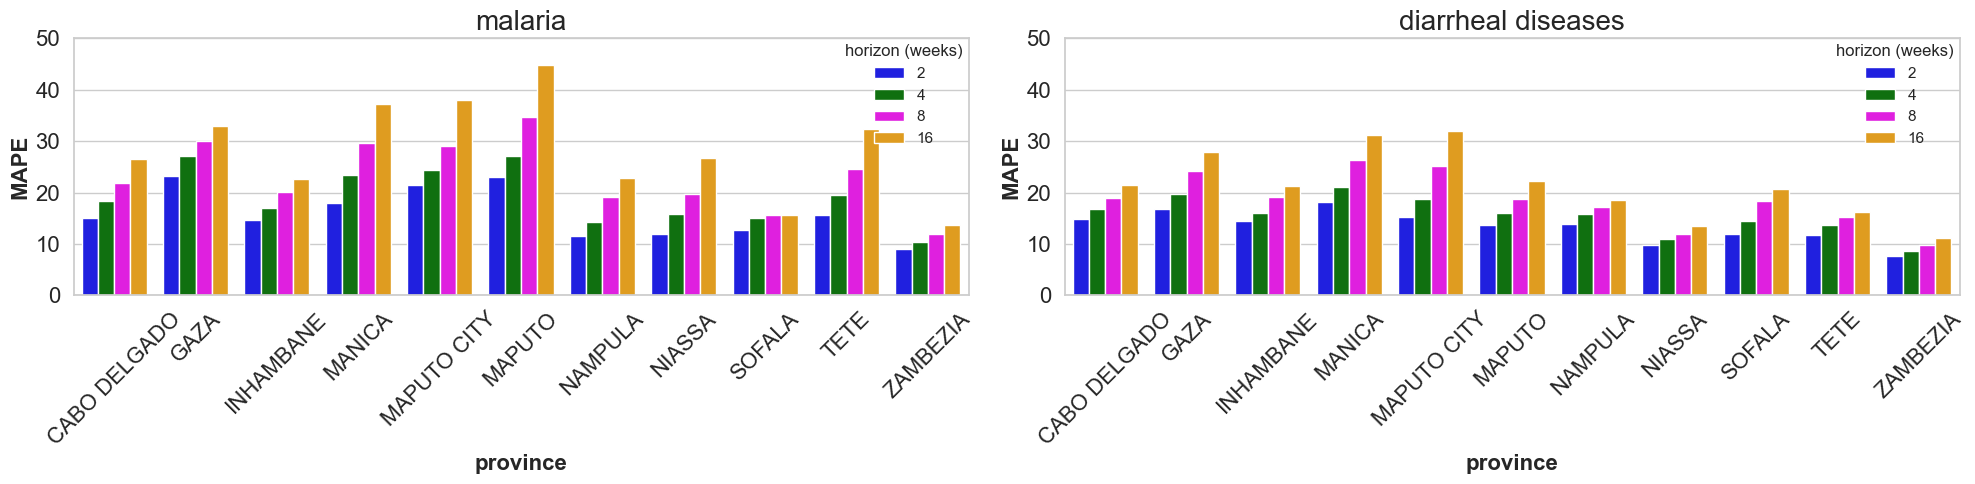

In [19]:
sns.set(style="whitegrid")

colors = ['blue','green','magenta','orange']
horizons = df_metrics['horizon'].unique()
color_dict = {}
for h in range(0,len(horizons)):
    color_dict[str(horizons[h])] = colors[h]

metric = 'MAPE'
model = 'WIS-Weighted Ensemble'
df_metrics_sel = df_metrics[(df_metrics.season=='all') & 
                            (df_metrics['metric'] == metric) & 
                            (df_metrics['model'] == model)]


df_metrics_sel['horizon'] = df_metrics_sel['horizon'].astype(str)

fig, axes = plt.subplots(nrows=1, ncols=len(data_types), figsize=(20, 5))
for j, data_type in enumerate(data_types):
    subset_df = df_metrics_sel[(df_metrics_sel['data'] == data_type)]
    sns.barplot(x='province', y='value', hue='horizon', data=subset_df, ax=axes[j], palette=color_dict)
    axes[j].set_ylim(bottom=0,top=50)
    axes[j].set_xticklabels(provinces,rotation=45)
    axes[j].set_ylabel(metric, fontsize=16)
    axes[j].legend(loc='upper right', borderaxespad=0,title='horizon (weeks)')
    axes[j].tick_params(labelsize=16)

axes[0].set_title('malaria',fontsize=20)
axes[1].set_title('diarrheal diseases',fontsize=20)
axes[0].set_xlabel('province',fontsize=16)
axes[1].set_xlabel('province',fontsize=16)
# axes[1].set_yticklabels('')
plt.tight_layout()
plt.show()

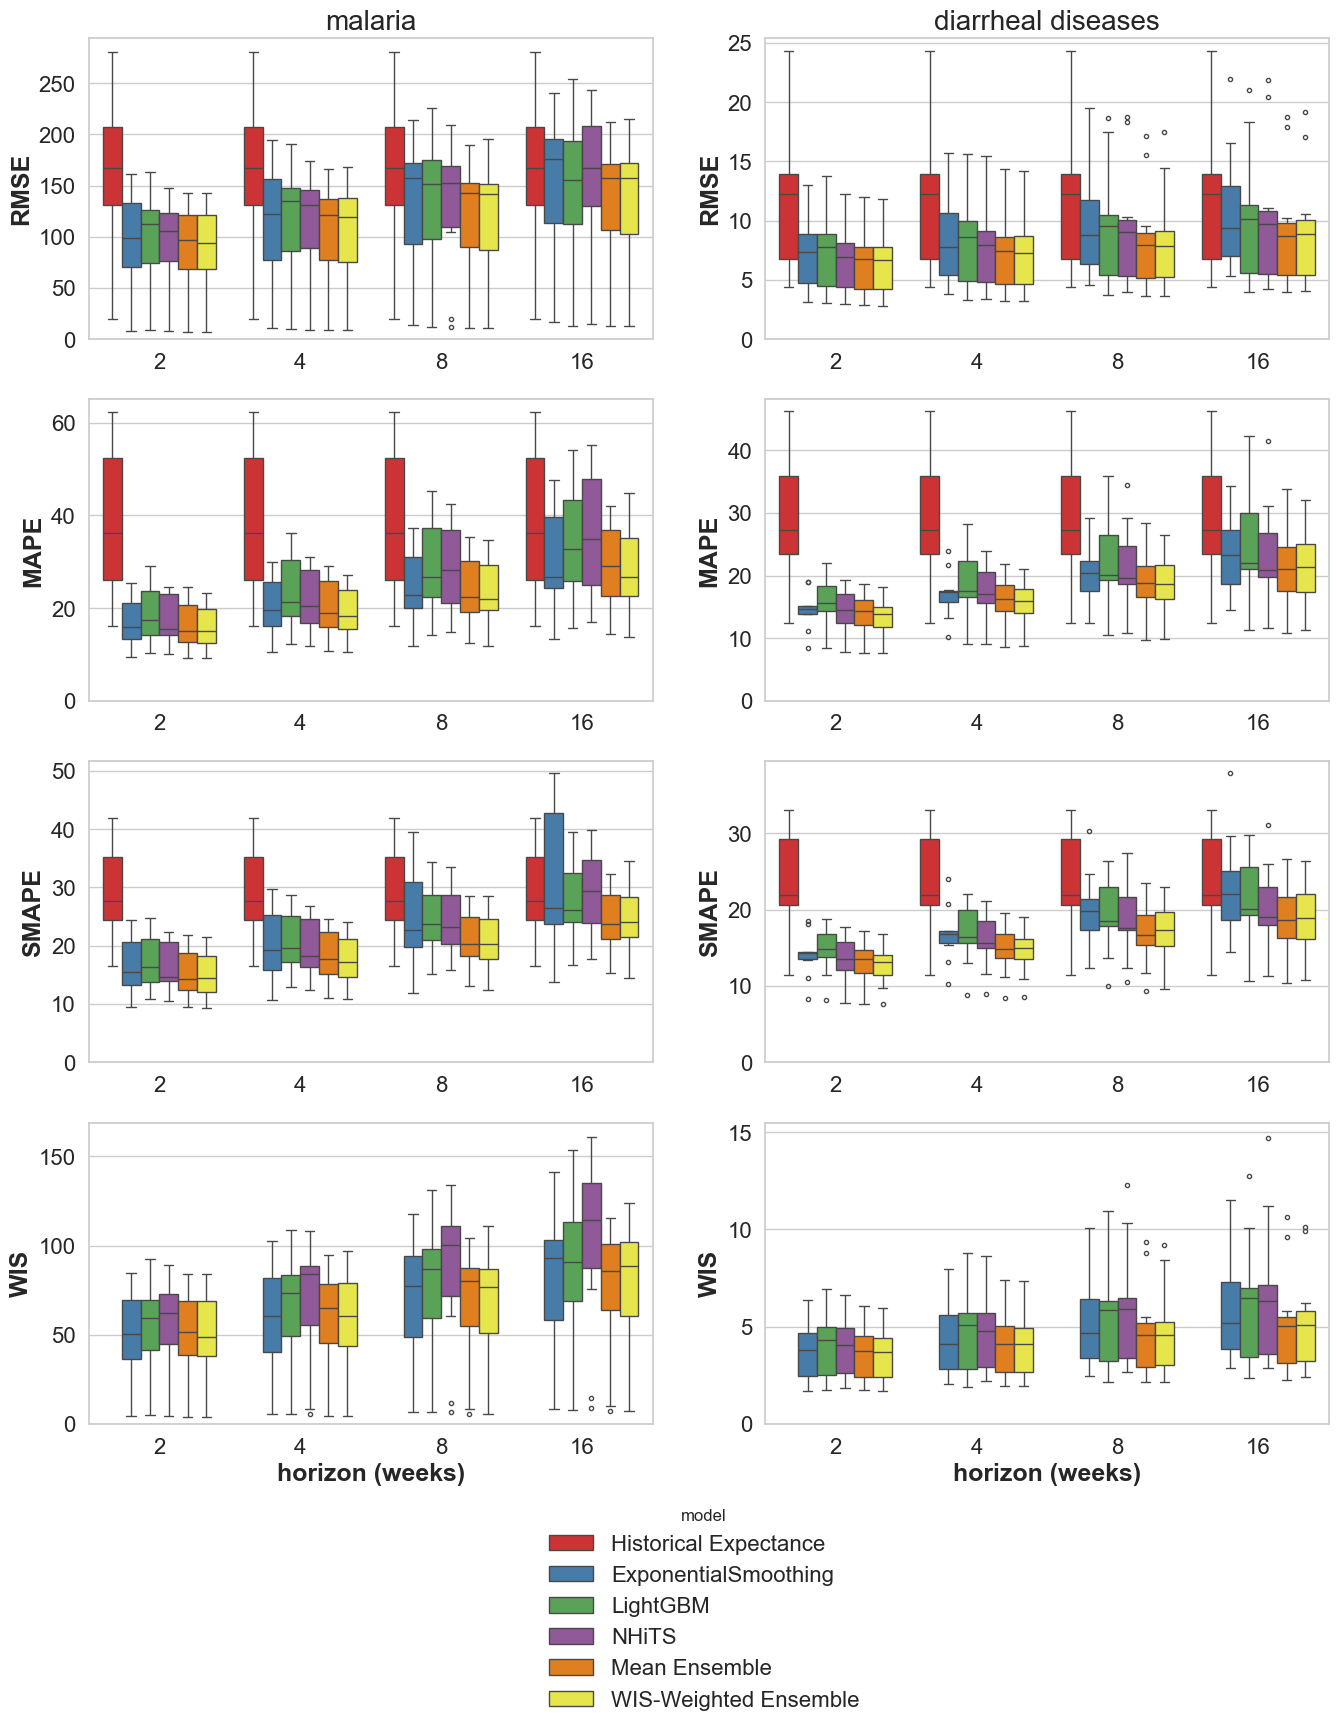

In [31]:
df_metrics_all = df_metrics[df_metrics.season=='all']
df_metrics_his_mean_all = df_metrics_his_mean[df_metrics_his_mean.season=='all']
df_metrics_all = pd.concat([df_metrics_his_mean_all,df_metrics_all])
sns.set(style="whitegrid")
data_types = ['malaria','diarrhea']

df_metrics_all = df_metrics_all.replace('LightGBM_Global','LightGBM')
df_metrics_all = df_metrics_all.replace('NHiTS_Global','NHiTS')

metrics = df_metrics_all['metric'].unique()
fig, axes = plt.subplots(nrows=len(metrics), ncols=len(data_types), figsize=(16, 4.5 * len(metrics)))
for j, data_type in enumerate(data_types):
    for i, metric in enumerate(metrics):
        ax = axes[i,j]
        subset_df = df_metrics_all[(df_metrics_all['metric'] == metric) & (df_metrics_all['data'] == data_type)]
        sns.boxplot(x='horizon', y='value', hue='model', data=subset_df, ax=ax, fliersize=3, palette="Set1")
        ax.set_ylim(bottom=0)
        ax.set_ylabel(metric, fontsize=18)
        ax.tick_params(labelsize=16)
        ax.set_xlabel('')
        ax.legend([])
   
axes[0,0].set_title('malaria',fontsize=20)
axes[0,1].set_title('diarrheal diseases',fontsize=20)
axes[len(metrics)-1,0].set_xlabel('horizon (weeks)', fontsize=18)
axes[len(metrics)-1,1].set_xlabel('horizon (weeks)', fontsize=18)
axes[len(metrics)-1,1].legend(bbox_to_anchor=(-0.4, -0.25), loc='upper left', borderaxespad=0, title='model', fontsize=16)
#plt.tight_layout()
plt.show()

C:\Users\ry2460\AppData\Local\Temp\ipykernel_8052\3584020758.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[len(horizons)-1,0].set_xticklabels(provinces,rotation=60)
C:\Users\ry2460\AppData\Local\Temp\ipykernel_8052\3584020758.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[len(horizons)-1,1].set_xticklabels(provinces,rotation=60)


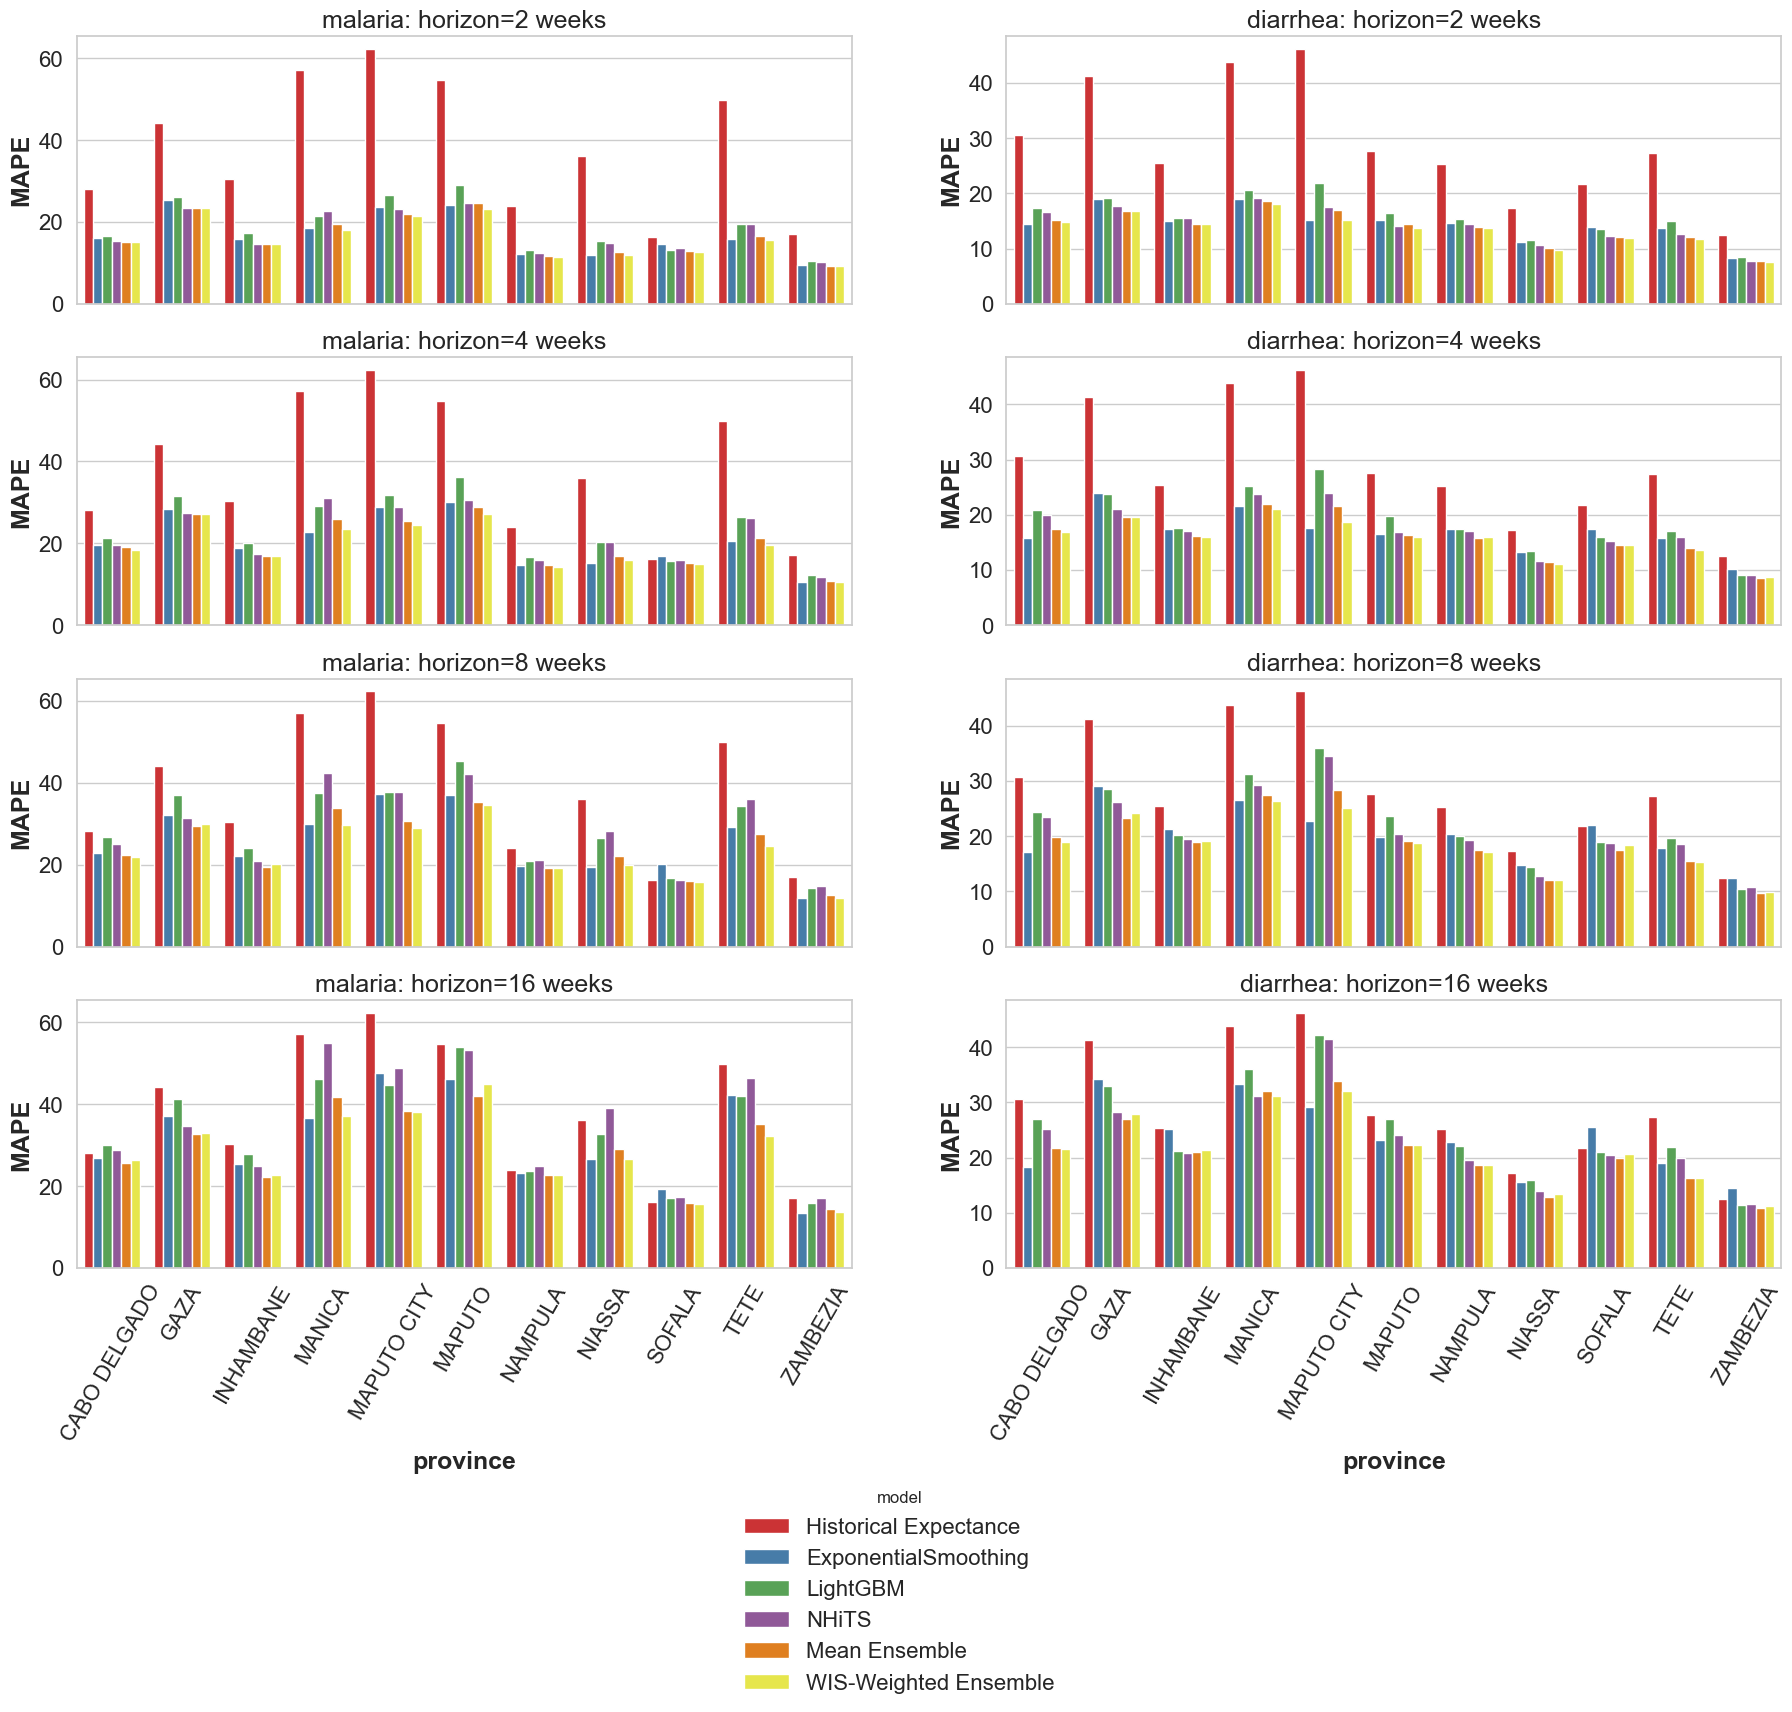

In [35]:
df_metrics_all = df_metrics[df_metrics.season=='all']
df_metrics_his_mean_all = df_metrics_his_mean[df_metrics_his_mean.season=='all']
df_metrics_all = pd.concat([df_metrics_his_mean_all,df_metrics_all])
sns.set(style="whitegrid")
data_types = ['malaria','diarrhea']

df_metrics_all = df_metrics_all.replace('LightGBM_Global','LightGBM')
df_metrics_all = df_metrics_all.replace('NHiTS_Global','NHiTS')

selected_metric = 'MAPE'
df_metrics_all = df_metrics_all[df_metrics_all.metric==selected_metric]

horizons = df_metrics_all['horizon'].unique()
fig, axes = plt.subplots(nrows=len(horizons), ncols=len(data_types), figsize=(22, 4 * len(metrics)))
for j, data_type in enumerate(data_types):
    for i, horizon in enumerate(horizons):
        ax = axes[i,j]
        subset_df = df_metrics_all[(df_metrics_all['horizon'] == horizon) & (df_metrics_all['data'] == data_type)]
        sns.barplot(x='province', y='value', hue='model', data=subset_df, ax=ax, palette="Set1")
        ax.set_title('{}: horizon={} weeks'.format(data_type,horizon), fontsize=18)
        ax.set_xlabel('')
        ax.set_xticklabels('')
        ax.set_ylabel(selected_metric, fontsize=18)
        ax.tick_params(labelsize=16)
        ax.legend([])
   
axes[len(horizons)-1,0].set_xlabel('province', fontsize=18)
axes[len(horizons)-1,1].set_xlabel('province', fontsize=18)
axes[len(horizons)-1,0].set_xticklabels(provinces,rotation=60)
axes[len(horizons)-1,1].set_xticklabels(provinces,rotation=60)
axes[len(horizons)-1,1].legend(bbox_to_anchor=(-0.35, -0.8), loc='upper left', borderaxespad=0, title='model', fontsize=16)
# plt.tight_layout()
plt.show()

In [22]:
print('************ WIS-Weighted Ensemble **************')

df_metrics1 = df_metrics[(df_metrics['season']=='all') &
                         (df_metrics["metric"]=='MAPE') &
                         (df_metrics['model']=='WIS-Weighted Ensemble')]
forecast_horizons = [2, 4, 8, 16] 
data_types = ['malaria','diarrhea']
for data in data_types:
     print('\n************ '+data +' **************')
     df_metrics2 = df_metrics1[(df_metrics1["data"]==data)]
     for h in forecast_horizons:
        print('horizon='+str(h))
        df_metrics3 = df_metrics2[(df_metrics2["horizon"]==h)]
        mean1 = np.round(df_metrics3['value'].mean(),2)
        min1 = np.round(df_metrics3['value'].min(),2)
        max1 = np.round(df_metrics3['value'].max(),2)
        print('mean='+str(mean1) + ' min='+str(min1) + ' max='+str(max1))

print('\n************ historical expectance **************')
df_metrics1 = df_metrics_his_mean[(df_metrics_his_mean['season']=='all') &
                                  (df_metrics_his_mean["metric"]=='MAPE') &
                                  (df_metrics_his_mean["data"]=='malaria') &
                                  (df_metrics_his_mean["horizon"]==2)]
mean1 = np.round(df_metrics1['value'].mean(),2)
min1 = np.round(df_metrics1['value'].min(),2)
max1 = np.round(df_metrics1['value'].max(),2)
print('\n************ malaria **************')
print('mean='+str(mean1) + ' min='+str(min1) + ' max='+str(max1))

df_metrics2 = df_metrics_his_mean[(df_metrics_his_mean['season']=='all') &
                                  (df_metrics_his_mean["metric"]=='MAPE') &
                                  (df_metrics_his_mean["data"]=='diarrhea') &
                                  (df_metrics_his_mean["horizon"]==2)]
mean2 = np.round(df_metrics2['value'].mean(),2)
min2 = np.round(df_metrics2['value'].min(),2)
max2 = np.round(df_metrics2['value'].max(),2)
print('\n************ diarrhea **************')
print('mean='+str(mean2) + ' min='+str(min2) + ' max='+str(max2))


************ WIS-Weighted Ensemble **************

************ malaria **************
horizon=2
mean=16.07 min=9.11 max=23.32
horizon=4
mean=19.32 min=10.47 max=27.2
horizon=8
mean=23.33 min=11.9 max=34.65
horizon=16
mean=28.48 min=13.73 max=44.91

************ diarrhea **************
horizon=2
mean=13.45 min=7.63 max=18.11
horizon=4
mean=15.62 min=8.67 max=21.02
horizon=8
mean=18.65 min=9.8 max=26.4
horizon=16
mean=21.5 min=11.25 max=32.01

************ historical expectance **************

************ malaria **************
mean=38.19 min=16.21 max=62.35

************ diarrhea **************
mean=29.0 min=12.46 max=46.2


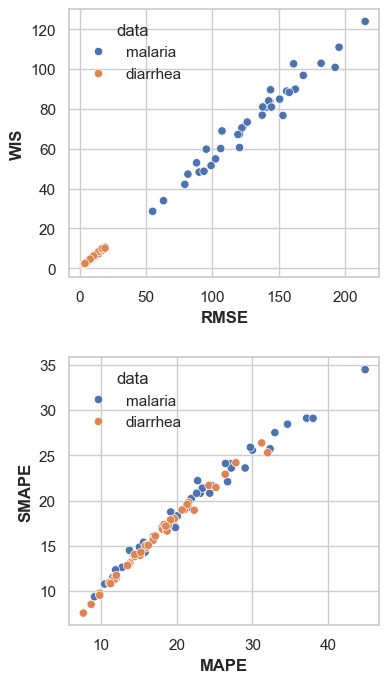

In [23]:
model = 'WIS-Weighted Ensemble'
metric1 = 'RMSE' 
metric2 = 'WIS' 
df_metrics_sel1 = df_metrics[(df_metrics['metric'] == metric1) & 
                            (df_metrics['model'] == model) &
                            (df_metrics['season'] == 'all')]

df_metrics_sel2 = df_metrics[(df_metrics['metric'] == metric2) & 
                            (df_metrics['model'] == model) &
                            (df_metrics['season'] == 'all')]

df_metrics_sel12 = df_metrics_sel1[['province','horizon','data','model']].copy()
df_metrics_sel12[metric1] = df_metrics_sel1['value'].values
df_metrics_sel12[metric2] = df_metrics_sel2['value'].values
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4, 8))
sns.scatterplot(x=metric1, y=metric2, hue='data', data=df_metrics_sel12, ax=axes[0])
sns.move_legend(axes[0], "upper left")

metric1 = 'MAPE'
metric2 = 'SMAPE'
df_metrics_sel1 = df_metrics[(df_metrics['metric'] == metric1) & 
                            (df_metrics['model'] == model) &
                            (df_metrics['season'] == 'all')]

df_metrics_sel2 = df_metrics[(df_metrics['metric'] == metric2) & 
                            (df_metrics['model'] == model) &
                            (df_metrics['season'] == 'all')]


df_metrics_sel12 = df_metrics_sel1[['province','horizon','data','model']].copy()
df_metrics_sel12[metric1] = df_metrics_sel1['value'].values
df_metrics_sel12[metric2] = df_metrics_sel2['value'].values
sns.scatterplot(x=metric1, y=metric2, hue='data', data=df_metrics_sel12, ax=axes[1])
sns.move_legend(axes[1], "upper left")
plt.subplots_adjust(hspace=0.3)

In [24]:
metric = 'MAPE'
model = 'WIS-Weighted Ensemble'
province = 'MAPUTO' #'MANICA' #'ZAMBEZIA' #
df_metrics_sel = df_metrics[(df_metrics.season=='all') & 
                            (df_metrics['metric'] == metric) & 
                            (df_metrics['model'] == model) & 
                            (df_metrics['province']==province)]
df_metrics_sel

province                  model  horizon season metric      value  \
581    MAPUTO  WIS-Weighted Ensemble        2    all   MAPE  23.092259   
1681   MAPUTO  WIS-Weighted Ensemble        4    all   MAPE  27.197906   
2781   MAPUTO  WIS-Weighted Ensemble        8    all   MAPE  34.646492   
3881   MAPUTO  WIS-Weighted Ensemble       16    all   MAPE  44.910876   
581    MAPUTO  WIS-Weighted Ensemble        2    all   MAPE  13.665263   
1681   MAPUTO  WIS-Weighted Ensemble        4    all   MAPE  15.933554   
2781   MAPUTO  WIS-Weighted Ensemble        8    all   MAPE  18.722170   
3881   MAPUTO  WIS-Weighted Ensemble       16    all   MAPE  22.300878   

          data  
581    malaria  
1681   malaria  
2781   malaria  
3881   malaria  
581   diarrhea  
1681  diarrhea  
2781  diarrhea  
3881  diarrhea

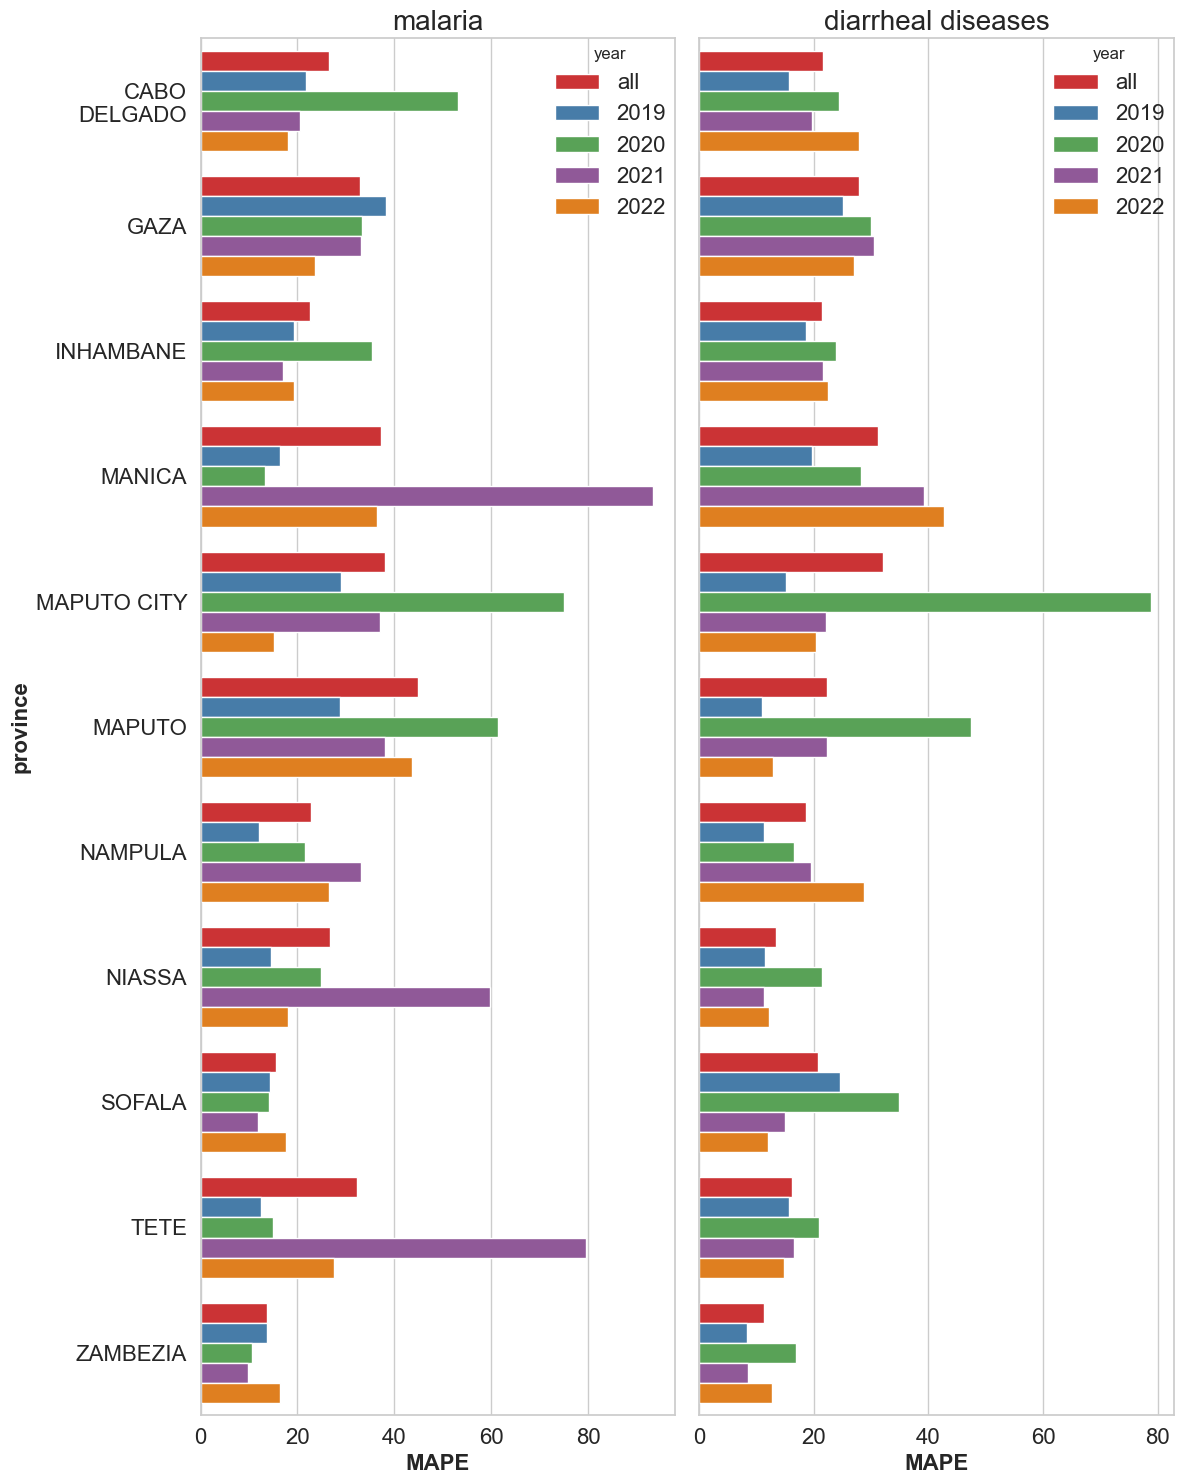

In [25]:
sns.set(style="whitegrid")

metric = 'MAPE'
horizon = 16
model = 'WIS-Weighted Ensemble'
df_metrics_sel = df_metrics[(df_metrics['metric'] == metric) & 
                            (df_metrics['horizon'] == horizon) & 
                            (df_metrics['model'] == model)]

df_metrics_sel = df_metrics_sel.replace('CABO DELGADO','CABO\nDELGADO')
df_metrics_sel = df_metrics_sel.replace('MAPUTO CIDADE','MAPUTO CITY')
df_metrics_sel = df_metrics_sel.replace('MAPUTO PROVINCIA','MAPUTO')

fig, axes = plt.subplots(nrows=1, ncols=len(data_types), figsize=(12, 15))
for j, data_type in enumerate(data_types):
    subset_df = df_metrics_sel[(df_metrics_sel['data'] == data_type)]
    sns.barplot(y='province', x='value', hue='season', data=subset_df, ax=axes[j],  orient='h', palette='Set1')
    axes[j].tick_params(labelsize=16)
    axes[j].set_xlabel(metric, fontsize=16)
    axes[j].legend(loc='upper right', borderaxespad=0,title='year', fontsize=16)

axes[0].set_title('malaria',fontsize=20)
axes[1].set_title('diarrheal diseases',fontsize=20)
axes[0].set_ylabel('province',fontsize=16)
axes[1].set_ylabel('')
axes[1].set_yticklabels('')
plt.tight_layout()
plt.show()

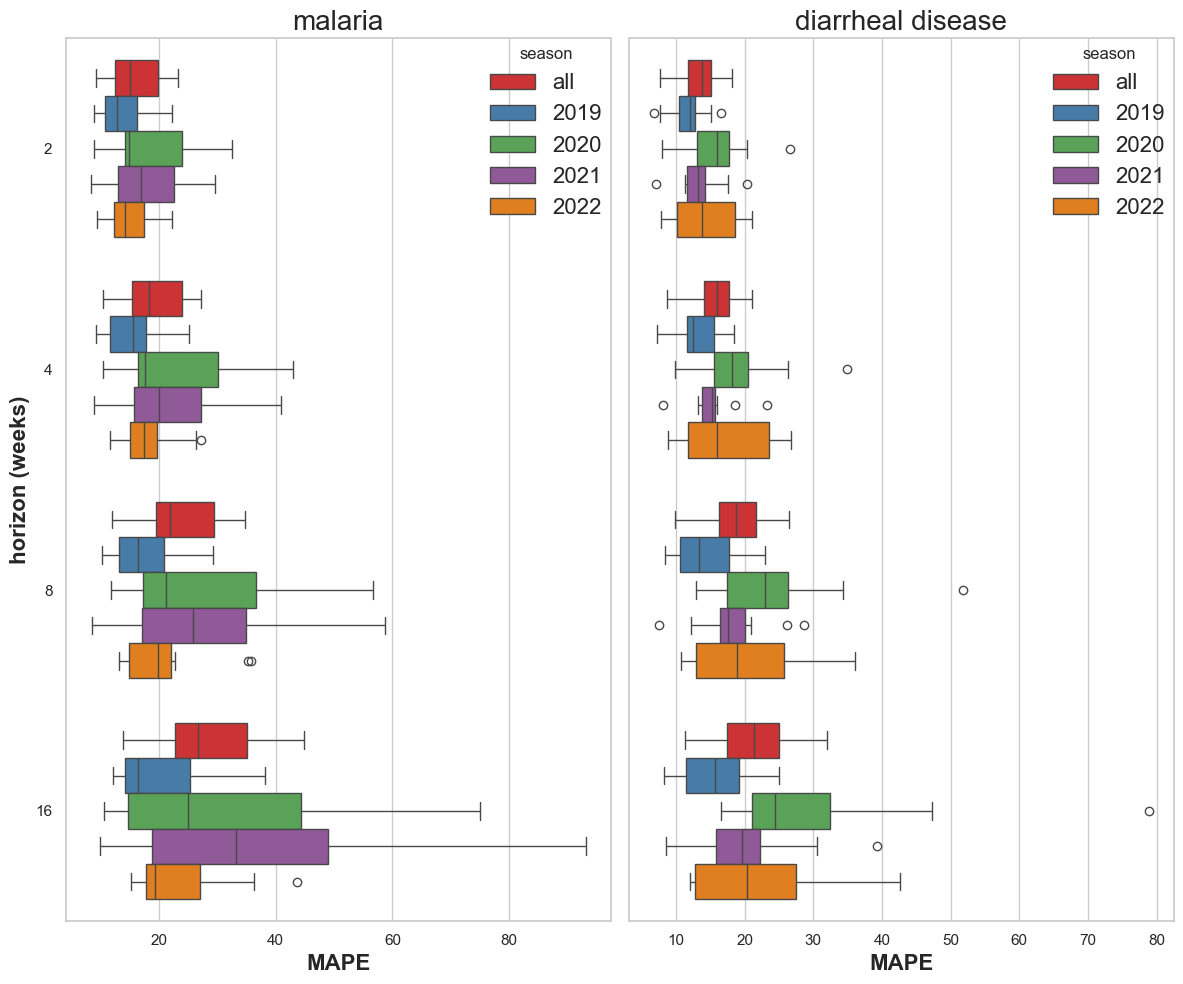

In [26]:
sns.set(style="whitegrid")

colors = ['blue','green','magenta','orange']
horizons = df_metrics['horizon'].unique()
color_dict = {}
for h in range(0,len(horizons)):
    color_dict[str(horizons[h])] = colors[h]

metric = 'MAPE'
model = 'WIS-Weighted Ensemble'
df_metrics_sel = df_metrics[(df_metrics['metric'] == metric) & 
                            (df_metrics['model'] == model)]

fig, axes = plt.subplots(nrows=1, ncols=len(data_types), figsize=(12, 10))
for j, data_type in enumerate(data_types):
    subset_df = df_metrics_sel[(df_metrics_sel['data'] == data_type)]
    #subset_df['horizon'] = subset_df['horizon'].astype(str)
    sns.boxplot(y='horizon', x='value', hue='season', data=subset_df, ax=axes[j],  orient='h', palette='Set1')
    #axes[j].set_xlim(left=0,right=70)
    axes[j].set_xlabel(metric, fontsize=16)
    axes[j].legend(loc='upper right', borderaxespad=0,title='season',fontsize=16)

axes[0].set_title('malaria',fontsize=20)
axes[1].set_title('diarrheal disease',fontsize=20)
axes[0].set_ylabel('horizon (weeks)', fontsize=16)
axes[1].set_ylabel('')
axes[1].set_yticklabels('')
plt.tight_layout()
plt.show()

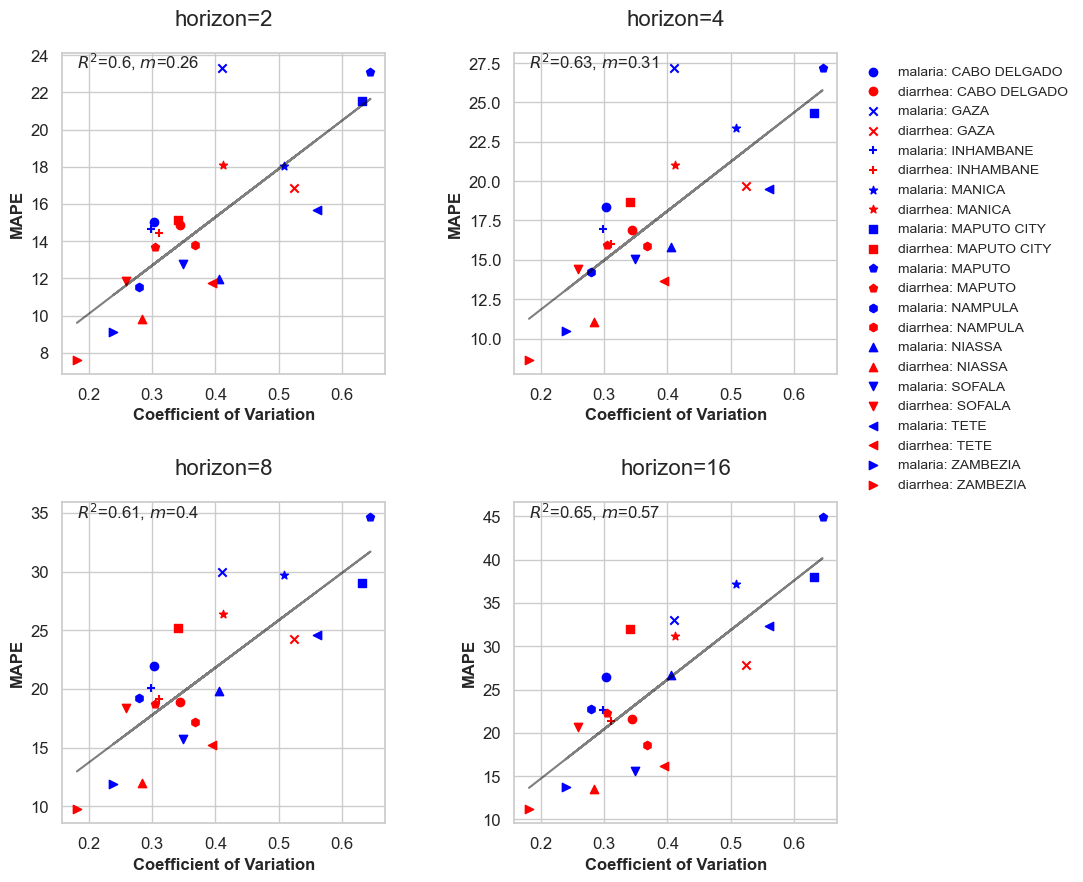

In [27]:
markers = ['o','x','+','*','s','p','h','^','v','<','>']

model = 'WIS-Weighted Ensemble' 
metric = 'MAPE'
data_type = 'combined' #'malaria' #'diarrhea' #

df_metrics_all = df_metrics[(df_metrics['season']=='all')]
df_metrics_all = df_metrics_all.replace('CABO\nDELGADO','CABO DELGADO')

horizons1 = np.array([[2,4],[8,16]])
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
for i in [0,1]:
    for j in [0,1]:
        
        horizon = horizons1[i,j]
        df_metrics_malaria = df_metrics_all[(df_metrics_all["metric"]==metric) &
                                        (df_metrics_all["horizon"]==horizon) &
                                        (df_metrics_all['model']==model) &
                                        (df_metrics_all['data']=='malaria')].set_index('province')

        df_metrics_diarrhea = df_metrics_all[(df_metrics_all["metric"]==metric) &
                                        (df_metrics_all["horizon"]==horizon) &
                                        (df_metrics_all['model']==model) &
                                        (df_metrics_all['data']=='diarrhea')].set_index('province')
        
        for idx,province in enumerate(provinces):
            if((data_type == 'malaria') | (data_type == 'combined')):
                axes[i,j].scatter(df_malaria_cv_per_province[province],df_metrics_malaria.loc[province].value,marker=markers[idx],
                            color='blue',label='malaria: '+provinces[idx])
            if((data_type == 'diarrhea') | (data_type == 'combined')):
                axes[i,j].scatter(df_diarrhea_cv_per_province[province],df_metrics_diarrhea.loc[province].value,marker=markers[idx],
                            color='red',label='diarrhea: ' +provinces[idx])

        if(data_type == 'malaria'):
            x = df_malaria_cv_per_province 
            y = df_metrics_malaria.value.values 
        elif(data_type == 'diarrhea'):
            x = df_diarrhea_cv_per_province
            y = df_metrics_diarrhea.value.values
        else:
            x = np.array(df_malaria_cv_per_province.tolist() + df_diarrhea_cv_per_province.tolist())
            y = np.array(df_metrics_malaria.value.values.tolist() + df_metrics_diarrhea.value.values.tolist())
        
        m,b = np.polyfit(x,y,1)
        linefit = m*x+b
        R2 = np.round(r2_score(y, linefit),2)
        axes[i,j].plot(x, linefit, color='black',alpha=0.5)
        axes[i,j].text(np.min(x), np.max(y), '$R^2$='+str(R2) +', $m$='+str(np.round(m/100,2)), fontsize = 12)

        axes[i,j].tick_params(labelsize=12)
        axes[i,j].set_xlabel('Coefficient of Variation',fontsize=12)
        axes[i,j].set_ylabel('MAPE',fontsize=12)
        axes[i,j].set_title('horizon='+str(horizon),fontsize=16, pad=20)

axes[0,1].legend(bbox_to_anchor=(1.03, 1),fontsize=10)
plt.subplots_adjust(hspace=0.4, wspace=0.4)

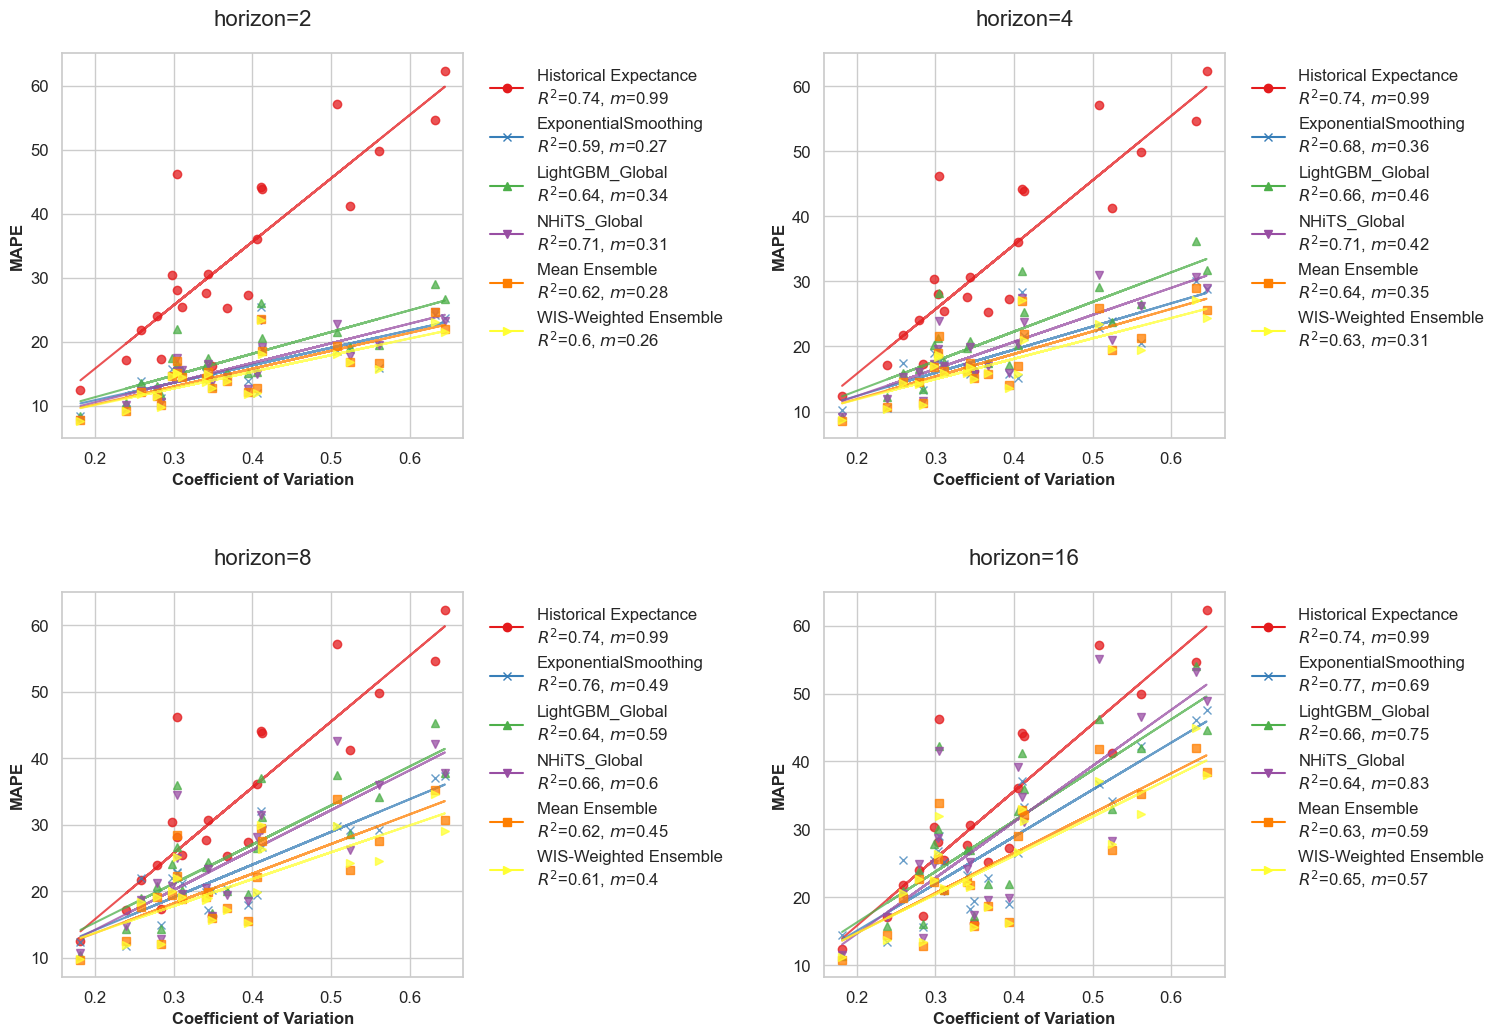

In [28]:
metric = 'MAPE'
data_type = 'combined' #'diarrhea' #'malaria' #

df_metrics_all = pd.concat([df_metrics_his_mean,df_metrics])
df_metrics_all = df_metrics_all[(df_metrics_all['season']=='all')]
df_metrics_all = df_metrics_all.replace('CABO\nDELGADO','CABO DELGADO')

models = df_metrics_all.model.unique()
colors = sns.color_palette("Set1")
markers = ['o','x','^','v','s','>'] 

horizons1 = np.array([[2,4],[8,16]])
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,12))
for i in [0,1]:
    for j in [0,1]:
        horizon = horizons1[i,j]
        pplots = []
        lplots = []
        for idx, model in enumerate(models):
            
            df_metrics_malaria = df_metrics_all[(df_metrics_all["metric"]==metric) &
                                            (df_metrics_all["horizon"]==horizon) &
                                            (df_metrics_all['model']==model) &
                                            (df_metrics_all['data']=='malaria')].set_index('province')

            df_metrics_diarrhea = df_metrics_all[(df_metrics_all["metric"]==metric) &
                                            (df_metrics_all["horizon"]==horizon) &
                                            (df_metrics_all['model']==model) &
                                            (df_metrics_all['data']=='diarrhea')].set_index('province')
            
            if(data_type == 'malaria'):
                x = df_malaria_cv_per_province 
                y = df_metrics_malaria.value.values 
            elif(data_type == 'diarrhea'):
                x = df_diarrhea_cv_per_province
                y = df_metrics_diarrhea.value.values
            else:
                x = np.array(df_malaria_cv_per_province.tolist() + df_diarrhea_cv_per_province.tolist())
                y = np.array(df_metrics_malaria.value.values.tolist() + df_metrics_diarrhea.value.values.tolist())
        
            m,b = np.polyfit(x,y,1)
            linefit = m*x+b
            R2 = np.round(r2_score(y, linefit),2)
            model = model.replace('-MV','')
            label = model + '\n$R^2$='+str(R2) +', $m$=' + str(np.round(m/100,2))
            pplot = axes[i,j].plot(x, y, color=colors[idx], linewidth=0, marker=markers[idx], alpha=0.75)
            lplot = axes[i,j].plot(x, linefit, color=colors[idx], alpha=0.75, label=label)
            pplots.append(pplot)
            lplots.append(lplot)

            ##generating the legend handles, with linestyle, markerstyle, color, and label
            ##copied from the plotted lines:
            handles = [
                Line2D(
                    [],[], marker=points[0].get_marker(), 
                    linestyle=lines[0].get_linestyle(),
                    color = lines[0].get_color(), 
                    label = lines[0].get_label(),
                ) for lines, points in zip(lplots,pplots)
            ]
            axes[i,j].legend(handles=handles,bbox_to_anchor=(1.03, 1),fontsize=12)

        axes[i,j].tick_params(labelsize=12)
        axes[i,j].set_xlabel('Coefficient of Variation',fontsize=12)
        axes[i,j].set_ylabel('MAPE',fontsize=12)
        axes[i,j].set_title('horizon='+str(horizon),fontsize=16, pad=20)

plt.subplots_adjust(hspace=0.4,wspace=0.9)

C:\Users\ry2460\AppData\Local\Temp\ipykernel_8052\3709577787.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(provinces,rotation=45)
C:\Users\ry2460\AppData\Local\Temp\ipykernel_8052\3709577787.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(provinces,rotation=45)


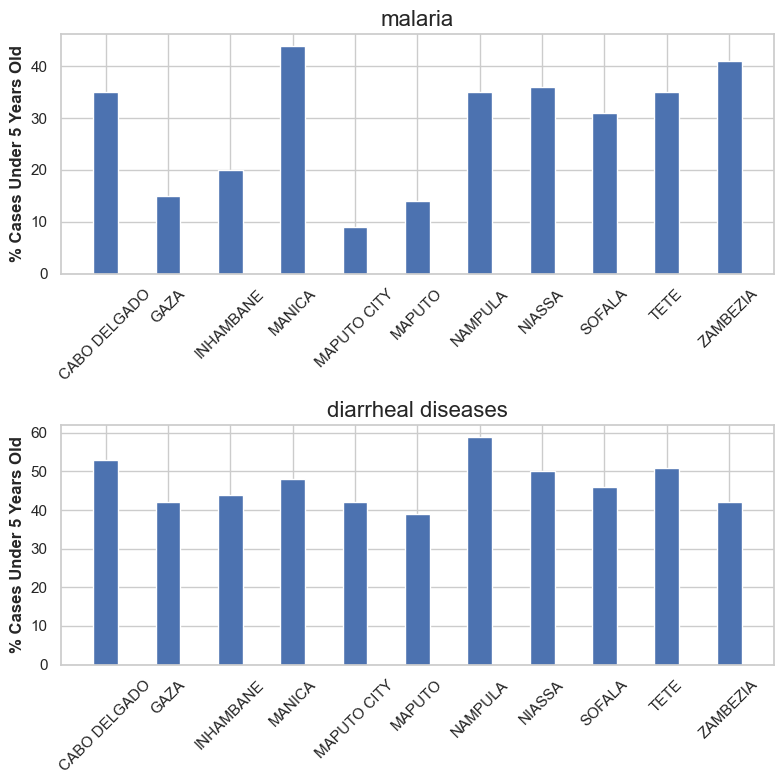

In [29]:
malaria_under5_19to22 = np.array([1592385,242562,670561,1144351,6972,32588,3906619,1217246,1633178,854506,4762786])
malaria_total_19to22 = np.array([4491595,1584134,3411036,2578675,75635,229288,11139047,3356671,5279274,2449590,11599022])
malaria_under5_per = np.round(100*malaria_under5_19to22/malaria_total_19to22)

diarrhea_under5_17to24 = np.array([194879,78183,65466,71088,104889,126345,275035,269024,276565,284652,279109])
diarrhea_total_17to24 = np.array([364272,187943,148173,148707,251135,321822,463180,536542,600120,559596,671554])
diarrhea_under5_per = np.round(100*diarrhea_under5_17to24/diarrhea_total_17to24)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))
axes[0].bar(provinces, malaria_under5_per, width=0.4)
axes[0].set_title('malaria', fontsize=16)
axes[0].set_ylabel('% Cases Under 5 Years Old')
axes[0].set_xticklabels(provinces,rotation=45)
axes[1].bar(provinces, diarrhea_under5_per, width=0.4)
axes[1].set_title('diarrheal diseases', fontsize=16)
axes[1].set_ylabel('% Cases Under 5 Years Old')
axes[1].set_xticklabels(provinces,rotation=45)
plt.tight_layout()